In [1]:
# 数据分析
import pandas as pd 
import numpy as np
import pickle
from tqdm import *
from rqfactor import *
from scipy.stats import spearmanr

# 米筐
import rqsdk
from rqdatac import *
init()

import seaborn as sns
import matplotlib.pyplot as plt
plt.rcParams['font.sans-serif']=['SimHei']
plt.rcParams['axes.unicode_minus']=False
plt.style.use('default')
plt.rcParams['figure.facecolor'] = 'white'

In [110]:
def get_Performance_analysis(T,year_day = 252):
    # 获取最终净值
    net_values = round(T[-1],4)
    
    # 计算几何年化收益率
    year_ret_sqrt = net_values**(year_day/len(T))-1
    year_ret_sqrt = round(year_ret_sqrt*100,2)
    
    # 计算年化波动率
    volitiy = T.pct_change().dropna().std()*np.sqrt(year_day)
    volitiy = round(volitiy*100,2)
    
    #计算夏普，无风险收益率记3%
    Sharpe = (year_ret_sqrt - 3)/volitiy
    Sharpe = round(Sharpe,2)

    # 计算最大回撤
    # 最大回撤结束点
    i = np.argmax((np.maximum.accumulate(T) - T)/np.maximum.accumulate(T))
    # 开始点
    j = np.argmax(T[:i])

    downlow = round((1-T[i]/T[j])*100,2)

    # 输出
    return [net_values,year_ret_sqrt,Sharpe,downlow,volitiy]

#### 基础设定

In [2]:
start_date = '2018-01-01'
end_date = '2023-06-01'

universe = '000300.XSHG'

# 动态券池
def INDEX_FIX(start_date,end_date,index_item):
    """
    :param start_date: 开始日 -> str
    :param end_date: 结束日 -> str 
    :param index_item: 指数代码 -> str 
    :return index_fix: 动态因子值 -> unstack
    """
    
    index = pd.DataFrame(dict([(k, pd.Series(v)) for k, v in index_components(index_item,start_date= start_date,end_date=end_date).items()])).T

    # 构建动态股票池 
    index_fix = index.unstack().reset_index().iloc[:,-2:]
    index_fix.columns = ['date','stock']
    index_fix.date = pd.to_datetime(index_fix.date)
    index_fix['level'] = True
    index_fix.dropna(inplace = True)
    index_fix = index_fix.set_index(['date','stock']).level.unstack()
    index_fix.fillna(False,inplace = True)

    return index_fix

index_fix = INDEX_FIX(start_date,end_date,universe)
stock_list = index_fix.columns.tolist()
date_list = index_fix.index.tolist()

In [3]:
month_date_list = get_trading_dates(start_date,end_date)

month_list = []

for i in range(1,len(month_date_list)):
    if month_date_list[i-1].month != month_date_list[i].month:
        month_list.append(month_date_list[i-1])

month_list = pd.to_datetime(month_list)

In [4]:
print(month_list)

DatetimeIndex(['2018-01-31', '2018-02-28', '2018-03-30', '2018-04-27',
               '2018-05-31', '2018-06-29', '2018-07-31', '2018-08-31',
               '2018-09-28', '2018-10-31', '2018-11-30', '2018-12-28',
               '2019-01-31', '2019-02-28', '2019-03-29', '2019-04-30',
               '2019-05-31', '2019-06-28', '2019-07-31', '2019-08-30',
               '2019-09-30', '2019-10-31', '2019-11-29', '2019-12-31',
               '2020-01-23', '2020-02-28', '2020-03-31', '2020-04-30',
               '2020-05-29', '2020-06-30', '2020-07-31', '2020-08-31',
               '2020-09-30', '2020-10-30', '2020-11-30', '2020-12-31',
               '2021-01-29', '2021-02-26', '2021-03-31', '2021-04-30',
               '2021-05-31', '2021-06-30', '2021-07-30', '2021-08-31',
               '2021-09-30', '2021-10-29', '2021-11-30', '2021-12-31',
               '2022-01-28', '2022-02-28', '2022-03-31', '2022-04-29',
               '2022-05-31', '2022-06-30', '2022-07-29', '2022-08-31',
      

#### BARRA数据获取

In [5]:
barra_style = ['momentum','beta','book_to_price','earnings_yield','liquidity','size','residual_volatility','non_linear_size','leverage','growth']

In [6]:
barra_dict = pd.read_pickle('./data/barra_dict.pkl')

In [7]:
barra_return = pd.read_pickle('./data/barra_return.pkl')

<AxesSubplot: xlabel='date'>

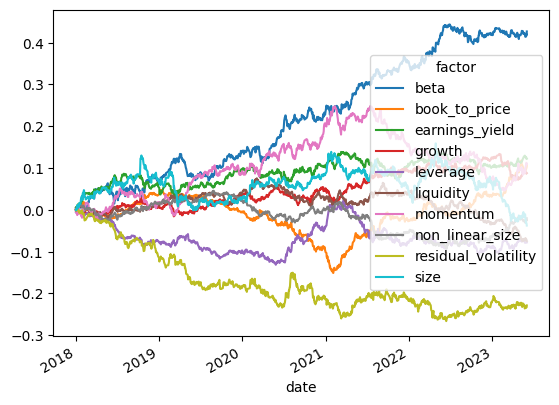

In [8]:
barra_return.cumsum().plot()

#### 风险因子构建

##### （1）估值价差

资金对于因子的追捧会进一步推升因子多头端的估值或者压低因子空头端的估值水平，由此加大因子多空组合的估值价差。估值价差指标越高，则说明该时点上因子拥挤度越高。

分别计算多空组合的相对估值指标的中位数，相对估值指标本文取通用的P/E(市盈率)与P/B(市净率)，为了解决估值指标在收益接近0时取值接近无穷等不良情况，本文取估值指标的倒数E/P和B/P，进行估值的刻画。

估值价差 = 空头组合的估值指标倒数中位数 - 多头组合的估值指标倒数中位数

总结：市净率表现会整体优于市盈率

In [16]:
momentum = barra_dict[barra_style[0]].mask(~index_fix)
momentum_top = momentum.mask((momentum.sub(momentum.quantile(0.9,axis = 1),axis = 0)) < 0)
momentum_bottom = momentum.mask(momentum.sub(momentum.quantile(0.1,axis = 1),axis = 0) > 0)

In [20]:
ep = execute_factor(Factor('ep_ratio_ttm'),stock_list,start_date,end_date).mask(~index_fix)
bp = execute_factor(Factor('book_to_market_ratio_lf'),stock_list,start_date,end_date).mask(~index_fix)

In [93]:
# 盈市率
ep_spread =  ep.mask(momentum_top.isnull()).median(axis = 1) - ep.mask(momentum_bottom.isnull()).median(axis = 1)
ep_spread_z60 = ((ep_spread - ep_spread.rolling(60).mean())/ep_spread.rolling(60).std())
ep_spread_z120 = ((ep_spread - ep_spread.rolling(120).mean())/ep_spread.rolling(120).std())
ep_spread_z240 = ((ep_spread - ep_spread.rolling(240).mean())/ep_spread.rolling(240).std())
mon_cumret = (barra_return['momentum']+1).cumprod()
mom_ret20 = barra_return['momentum'].rolling(20).sum().shift(-20)
mom_ret60 = barra_return['momentum'].rolling(60).sum().shift(-60)

df = pd.concat([ep_spread.to_frame('crowd'),ep_spread_z60.to_frame('crowd_z60'),ep_spread_z120.to_frame('crowd_z120'),ep_spread_z240.to_frame('crowd_z240'),mon_cumret.to_frame('mon_cumret'),mom_ret20.to_frame('mom_ret20'),mom_ret60.to_frame('mom_ret60')],axis = 1).dropna()

df.corr()

,crowd,crowd_z60,crowd_z120,crowd_z240,mon_cumret,mom_ret20,mom_ret60
crowd,1.000000,0.532422,0.654462,0.777706,-0.050374,-0.216664,-0.287467
crowd_z60,0.532422,1.000000,0.841707,0.719283,-0.007036,0.003384,0.008947
crowd_z120,0.654462,0.841707,1.000000,0.917234,0.109445,-0.022556,-0.089278
crowd_z240,0.777706,0.719283,0.917234,1.000000,0.208642,-0.097560,-0.233632
mon_cumret,-0.050374,-0.007036,0.109445,0.208642,1.000000,-0.220319,-0.443381
mom_ret20,-0.216664,0.003384,-0.022556,-0.097560,-0.220319,1.000000,0.586361
mom_ret60,-0.287467,0.008947,-0.089278,-0.233632,-0.443381,0.586361,1.000000


In [98]:
# 市净率
bp_spread = bp.mask(momentum_top.isnull()).median(axis = 1) - bp.mask(momentum_bottom.isnull()).median(axis = 1)
bp_spread_z60 = ((bp_spread - bp_spread.rolling(60).mean())/bp_spread.rolling(60).std())
bp_spread_z120 = ((bp_spread - bp_spread.rolling(120).mean())/bp_spread.rolling(120).std())
bp_spread_z240 = ((bp_spread - bp_spread.rolling(240).mean())/bp_spread.rolling(240).std())
mon_cumret = (barra_return['momentum']+1).cumprod()
mom_ret20 = barra_return['momentum'].rolling(20).sum().shift(-20)
mom_ret60 = barra_return['momentum'].rolling(60).sum().shift(-60)

df = pd.concat([bp_spread.to_frame('crowd'),bp_spread_z60.to_frame('crowd_z60'),bp_spread_z120.to_frame('crowd_z120'),bp_spread_z240.to_frame('crowd_z240'),mon_cumret.to_frame('mon_cumret'),mom_ret20.to_frame('mom_ret20'),mom_ret60.to_frame('mom_ret60')],axis = 1).dropna()

df.corr()

,crowd,crowd_z60,crowd_z120,crowd_z240,mon_cumret,mom_ret20,mom_ret60
crowd,1.000000,0.393187,0.481474,0.638610,-0.208552,-0.255447,-0.326118
crowd_z60,0.393187,1.000000,0.887175,0.728580,0.245675,-0.067209,-0.053801
crowd_z120,0.481474,0.887175,1.000000,0.894557,0.315638,-0.075640,-0.083331
crowd_z240,0.638610,0.728580,0.894557,1.000000,0.296636,-0.099950,-0.168035
mon_cumret,-0.208552,0.245675,0.315638,0.296636,1.000000,-0.220319,-0.443381
mom_ret20,-0.255447,-0.067209,-0.075640,-0.099950,-0.220319,1.000000,0.586361
mom_ret60,-0.326118,-0.053801,-0.083331,-0.168035,-0.443381,0.586361,1.000000


In [111]:
plt.rcParams['font.sans-serif']=['SimHei']#中文乱码
plt.rcParams['axes.unicode_minus']=False#中文乱码

<AxesSubplot: title={'center': '拥挤度_估值价差系数_未来60日收益'}, xlabel='date'>

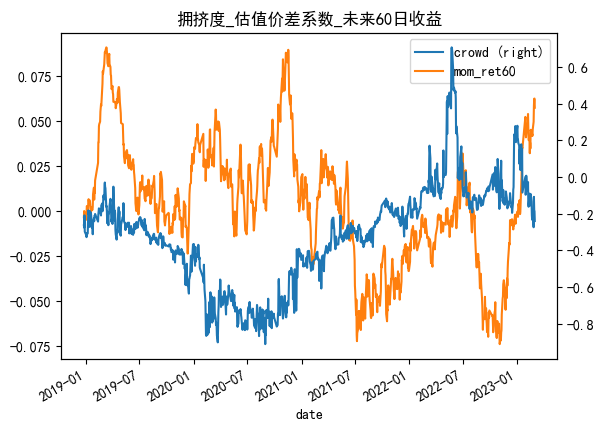

In [109]:
df[['crowd','mom_ret60']].plot(secondary_y='crowd',title = '拥挤度_估值价差系数_未来60日收益')

<AxesSubplot: title={'center': '拥挤度_估值价差系数_分层收益'}, xlabel='crowd_group'>

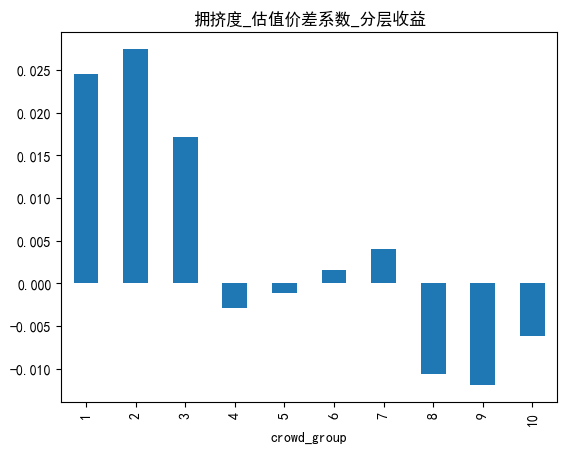

In [110]:
g = 10
df['crowd_group'] = pd.qcut(df.crowd,g, list(range(1,g+1))).to_list()
df.groupby(['crowd_group']).mom_ret60.mean().plot(kind = 'bar',title = '拥挤度_估值价差系数_分层收益')

##### （2）配对相关性

配对相关性从股票同涨同跌的特征来度量因子的拥挤程度。资金对于因子的追捧会加剧这一类股票同涨同跌的特性，因此配对相关性指标越大则因子越拥挤。

在截面观测日回看3个月，将多空头组合内的成分股日收益等权，计算多空组合的日收益。分别计算组内成分股和多空头组合的日收益相关系数，并取均值，计算多空头配对相关性。

+ 多头配对相关性 = Mean(Corr(个股 i3 个月, 多头组合均收益 3 个月))

+ 空头配对相关性 = Mean(Corr(个股 i3 个月, 空头组合均收益 3 个月))

+ 配对相关性指标 = 多头配对相关性 +空头配对相关性

总结：空头配对相关性对于空头的剥离效果较好，多头配对相关性对于多头剥离效果较好

In [227]:
ret = get_price(stock_list,get_previous_trading_date(start_date,60),end_date,fields = 'close').close.unstack('order_book_id').pct_change().dropna(how = 'all')

In [228]:
momentum = barra_dict[barra_style[0]].mask(~index_fix)
momentum_top = momentum.mask((momentum.sub(momentum.quantile(0.9,axis = 1),axis = 0)) < 0)
momentum_bottom = momentum.mask(momentum.sub(momentum.quantile(0.1,axis = 1),axis = 0) > 0)

In [229]:
match_dict = {}

for i in tqdm(date_list):
    start_date_temp = get_previous_trading_date(i,60)
    end_date_temp = i
    # 多头组配对相关性
    stock_list_top_temp = momentum_top.loc[i].dropna().index.tolist()
    top_ret60 = ret.loc[start_date_temp:end_date_temp][stock_list_top_temp]
    top_ret60['mean'] = top_ret60.mean(axis = 1)
    top_match = top_ret60.corr()['mean'].drop('mean').mean()
    # 空头组配对相关性
    stock_list_bottom_temp = momentum_bottom.loc[i].dropna().index.tolist()
    bottom_ret60 = ret.loc[start_date_temp:end_date_temp][stock_list_bottom_temp]
    bottom_ret60['mean'] = bottom_ret60.mean(axis = 1)
    bottom_match = bottom_ret60.corr()['mean'].drop('mean').mean()

    match_dict[i] = {'top':top_match,'bottom':bottom_match}

100%|██████████| 1314/1314 [00:04<00:00, 281.11it/s]


In [231]:
match_df = pd.DataFrame(match_dict).T
match_df['match'] = match_df['top'] + match_df['bottom']
match = - match_df['match']

match_z60 = ((match - match.rolling(60).mean())/match.rolling(60).std())
match_z120 = ((match - match.rolling(120).mean())/match.rolling(120).std())
match_z240 = ((match - match.rolling(240).mean())/match.rolling(240).std())
mon_cumret = (barra_return['momentum']+1).cumprod()
mom_ret20 = barra_return['momentum'].rolling(20).sum().shift(-20)
mom_ret60 = barra_return['momentum'].rolling(60).sum().shift(-60)

df = pd.concat([match.to_frame('crowd'),-match_df['top'].to_frame('crowd_top'),-match_df['bottom'].to_frame('crowd_bottom'),match_z60.to_frame('crowd_z60'),match_z120.to_frame('crowd_z120'),match_z240.to_frame('crowd_z240'),mon_cumret.to_frame('mon_cumret'),mom_ret20.to_frame('mom_ret20'),mom_ret60.to_frame('mom_ret60')],axis = 1).dropna()

df.corr()

,crowd,crowd_top,crowd_bottom,crowd_z60,crowd_z120,crowd_z240,mon_cumret,mom_ret20,mom_ret60
crowd,1.000000,0.760048,0.831956,0.486497,0.655286,0.749780,0.323598,-0.265715,-0.450174
crowd_top,0.760048,1.000000,0.271753,0.414451,0.574131,0.496508,-0.048858,-0.269146,-0.364027
crowd_bottom,0.831956,0.271753,1.000000,0.366589,0.480212,0.686417,0.520920,-0.163698,-0.355851
crowd_z60,0.486497,0.414451,0.366589,1.000000,0.816128,0.659889,-0.015721,0.058344,0.045940
crowd_z120,0.655286,0.574131,0.480212,0.816128,1.000000,0.884800,-0.010874,-0.007278,-0.033196
crowd_z240,0.749780,0.496508,0.686417,0.659889,0.884800,1.000000,0.108900,-0.032038,-0.068342
mon_cumret,0.323598,-0.048858,0.520920,-0.015721,-0.010874,0.108900,1.000000,-0.220319,-0.443381
mom_ret20,-0.265715,-0.269146,-0.163698,0.058344,-0.007278,-0.032038,-0.220319,1.000000,0.586361
mom_ret60,-0.450174,-0.364027,-0.355851,0.045940,-0.033196,-0.068342,-0.443381,0.586361,1.000000


<AxesSubplot: title={'center': '拥挤度_配对相关性（多空）_未来60日收益'}>

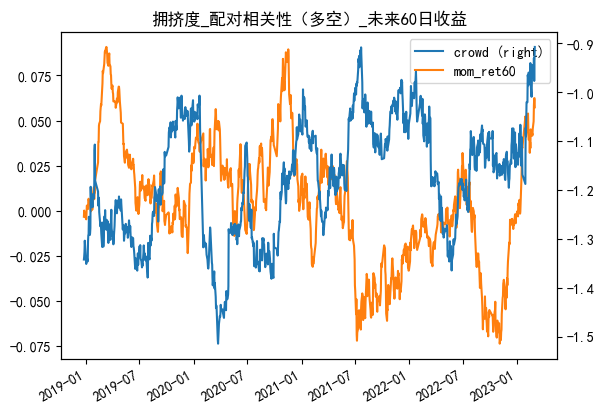

In [236]:
df[['crowd','mom_ret60']].plot(secondary_y='crowd',title = '拥挤度_配对相关性（多空）_未来60日收益')

<AxesSubplot: title={'center': '拥挤度_配对相关性（多空）_分层收益'}, xlabel='crowd_group'>

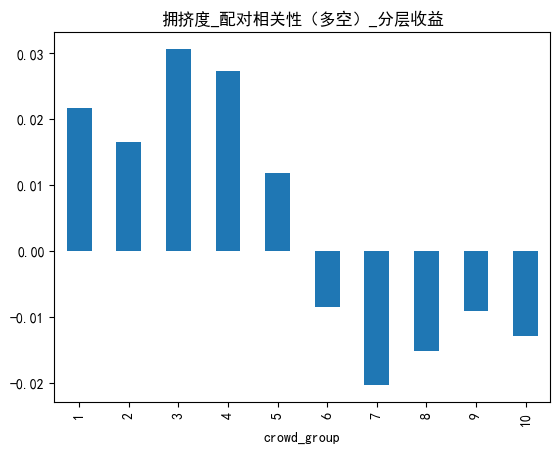

In [237]:
g = 10
df['crowd_group'] = pd.qcut(df.crowd,g, list(range(1,g+1))).to_list()
df.groupby(['crowd_group']).mom_ret60.mean().plot(kind = 'bar',title = '拥挤度_配对相关性（多空）_分层收益')

<AxesSubplot: title={'center': '拥挤度_配对相关性（多头）_未来60日收益'}>

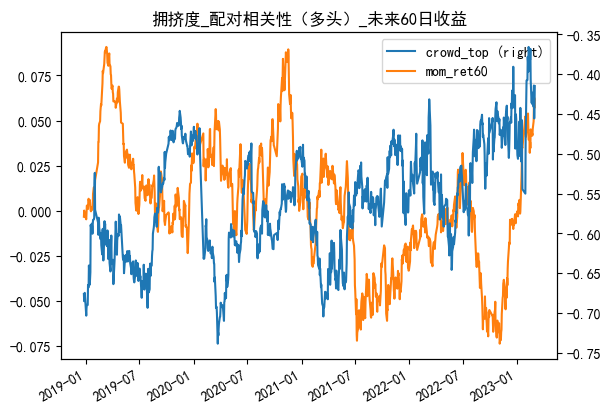

In [238]:
df[['crowd_top','mom_ret60']].plot(secondary_y='crowd_top',title = '拥挤度_配对相关性（多头）_未来60日收益')

<AxesSubplot: title={'center': '拥挤度_配对相关性(多头)_分层收益'}, xlabel='crowd_group'>

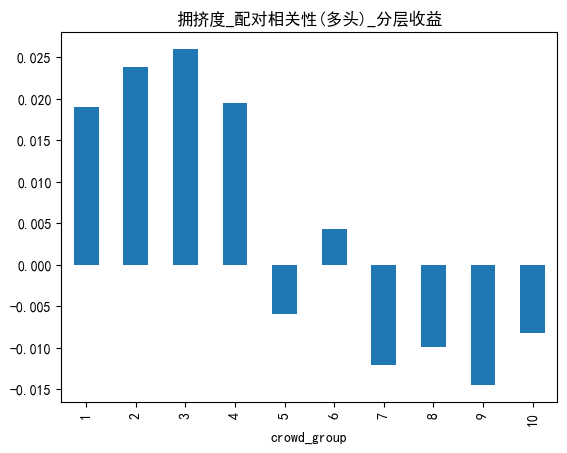

In [239]:
g = 10
df['crowd_group'] = pd.qcut(df.crowd_top,g, list(range(1,g+1))).to_list()
df.groupby(['crowd_group']).mom_ret60.mean().plot(kind = 'bar',title = '拥挤度_配对相关性(多头)_分层收益')

<AxesSubplot: title={'center': '拥挤度_配对相关性（空头）_未来60日收益'}>

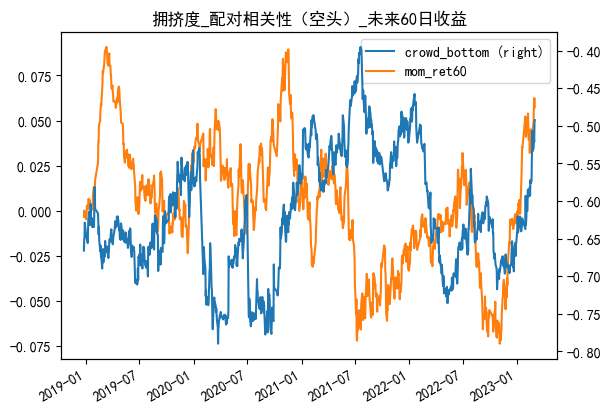

In [240]:
df[['crowd_bottom','mom_ret60']].plot(secondary_y='crowd_bottom',title = '拥挤度_配对相关性（空头）_未来60日收益')

<AxesSubplot: title={'center': '拥挤度_配对相关性（空头）_分层收益'}, xlabel='crowd_group'>

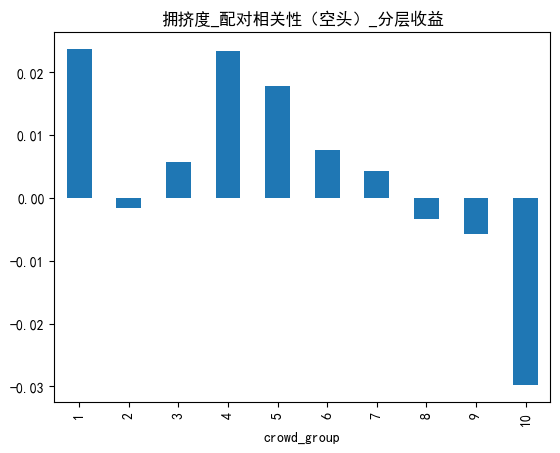

In [241]:
g = 10
df['crowd_group'] = pd.qcut(df.crowd_bottom,g, list(range(1,g+1))).to_list()
df.groupby(['crowd_group']).mom_ret60.mean().plot(kind = 'bar',title = '拥挤度_配对相关性（空头）_分层收益')

##### （3）因子波动率

由于资金的流入会加剧因子收益率的波动，因此Bonne等(2018)从使用因子波动率衡量当前因子拥挤程度。本文中，在截面观测日回看3个月，将多空头组合内的成分股日收益等权，计算多空头组合的日收益，并计算多空头组合日收益序列的标准差。将历史时点上的A股市场上符合要求的股票等权组合，构建市场组合，用同样的方法计算市场组合的收益并计算标准差，因此期望相对波动率度量与因子波动率正相关。

+ 多头组合因子波动 = STD（多头组合）/STD（市场组合）

+ 多空组合因子波动 = STD（多空组合）/STD（市场组合）

In [155]:
ret = get_price(stock_list,get_previous_trading_date(start_date,60),end_date,fields = 'close').close.unstack('order_book_id').pct_change().dropna(how = 'all')

In [ ]:
momentum = barra_dict[barra_style[0]].mask(~index_fix)
momentum_top = momentum.mask((momentum.sub(momentum.quantile(0.9,axis = 1),axis = 0)) < 0)
momentum_bottom = momentum.mask(momentum.sub(momentum.quantile(0.1,axis = 1),axis = 0) > 0)

In [160]:
std_dict = {}

for i in tqdm(date_list):
    start_date_temp = get_previous_trading_date(i,60)
    end_date_temp = i
    # 多头组波动率
    stock_list_top_temp = momentum_top.loc[i].dropna().index.tolist()
    top_ret60 = ret.loc[start_date_temp:end_date_temp][stock_list_top_temp]
    top_ret60_std = top_ret60.mean(axis = 1).std()
    # 空头组波动率
    stock_list_bottom_temp = momentum_bottom.loc[i].dropna().index.tolist()
    bottom_ret60 = ret.loc[start_date_temp:end_date_temp][stock_list_bottom_temp]
    top_bottom_ret60_std = (top_ret60.mean(axis = 1) - bottom_ret60.mean(axis = 1)).std()
    # 市场组合收益率
    stock_list_temp = momentum.loc[i].dropna().index.tolist()
    ret60 = ret.loc[start_date_temp:end_date_temp][stock_list_temp]
    ret60_std = ret60.mean(axis = 1).std()

    std_dict[i] = {'top':top_ret60_std/ret60_std,'top_bottom':top_bottom_ret60_std/ret60_std}

100%|██████████| 1314/1314 [00:03<00:00, 360.67it/s]


In [165]:
std_df = pd.DataFrame(std_dict).T
std_top = std_df['top']


std_z60 = ((std_top - std_top.rolling(60).mean())/std_top.rolling(60).std())
std_z120 = ((std_top - std_top.rolling(120).mean())/std_top.rolling(120).std())
std_z240 = ((std_top - std_top.rolling(240).mean())/std_top.rolling(240).std())
mon_cumret = (barra_return['momentum']+1).cumprod()
mom_ret20 = barra_return['momentum'].rolling(20).sum().shift(-20)
mom_ret60 = barra_return['momentum'].rolling(60).sum().shift(-60)

df = pd.concat([std_top.to_frame('crowd'),std_z60.to_frame('crowd_z60'),std_z120.to_frame('crowd_z120'),std_z240.to_frame('crowd_z240'),mon_cumret.to_frame('mon_cumret'),mom_ret20.to_frame('mom_ret20'),mom_ret60.to_frame('mom_ret60')],axis = 1).dropna()

df.corr()

,crowd,crowd_z60,crowd_z120,crowd_z240,mon_cumret,mom_ret20,mom_ret60
crowd,1.000000,0.320440,0.469896,0.591308,0.787683,-0.138467,-0.386081
crowd_z60,0.320440,1.000000,0.854327,0.677458,0.125963,0.155566,0.162704
crowd_z120,0.469896,0.854327,1.000000,0.879463,0.266748,0.138048,0.073573
crowd_z240,0.591308,0.677458,0.879463,1.000000,0.460166,0.098931,0.044845
mon_cumret,0.787683,0.125963,0.266748,0.460166,1.000000,-0.220319,-0.443381
mom_ret20,-0.138467,0.155566,0.138048,0.098931,-0.220319,1.000000,0.586361
mom_ret60,-0.386081,0.162704,0.073573,0.044845,-0.443381,0.586361,1.000000


<AxesSubplot: title={'center': '拥挤度_因子波动率（多头）_分层收益'}>

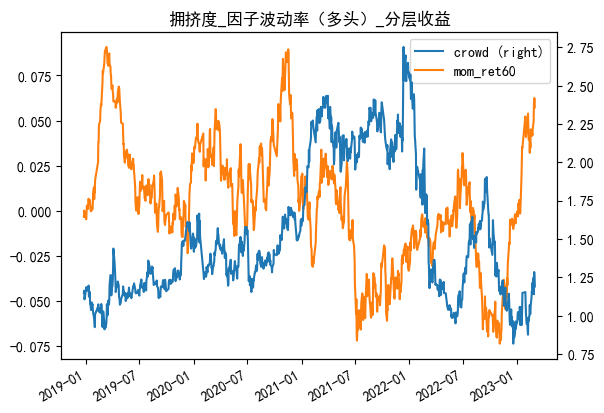

In [167]:
df[['crowd','mom_ret60']].plot(secondary_y='crowd',title = '拥挤度_因子波动率（多头）_分层收益')

<AxesSubplot: title={'center': '拥挤度_因子波动率（多头）_分层收益'}, xlabel='crowd_group'>

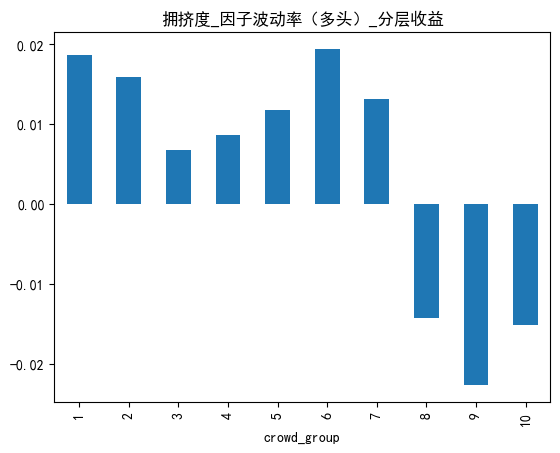

In [168]:
g = 10
df['crowd_group'] = pd.qcut(df.crowd,g, list(range(1,g+1))).to_list()
df.groupby(['crowd_group']).mom_ret60.mean().plot(kind = 'bar',title = '拥挤度_因子波动率（多头）_分层收益')

In [161]:
std_df = pd.DataFrame(std_dict).T
std_top_bottom = std_df['top_bottom']


std_z60 = ((std_top_bottom - std_top_bottom.rolling(60).mean())/std_top_bottom.rolling(60).std())
std_z120 = ((std_top_bottom - std_top_bottom.rolling(120).mean())/std_top_bottom.rolling(120).std())
std_z240 = ((std_top_bottom - std_top_bottom.rolling(240).mean())/std_top_bottom.rolling(240).std())
mon_cumret = (barra_return['momentum']+1).cumprod()
mom_ret20 = barra_return['momentum'].rolling(20).sum().shift(-20)
mom_ret60 = barra_return['momentum'].rolling(60).sum().shift(-60)

df = pd.concat([std_top_bottom.to_frame('crowd'),std_z60.to_frame('crowd_z60'),std_z120.to_frame('crowd_z120'),std_z240.to_frame('crowd_z240'),mon_cumret.to_frame('mon_cumret'),mom_ret20.to_frame('mom_ret20'),mom_ret60.to_frame('mom_ret60')],axis = 1).dropna()

df.corr()

,crowd,crowd_z60,crowd_z120,crowd_z240,mon_cumret,mom_ret20,mom_ret60
crowd,1.000000,0.348608,0.493887,0.570736,0.656545,-0.305378,-0.551930
crowd_z60,0.348608,1.000000,0.844492,0.660569,0.198036,-0.057338,-0.087099
crowd_z120,0.493887,0.844492,1.000000,0.848243,0.272713,-0.052237,-0.124132
crowd_z240,0.570736,0.660569,0.848243,1.000000,0.452352,-0.074533,-0.134293
mon_cumret,0.656545,0.198036,0.272713,0.452352,1.000000,-0.220319,-0.443381
mom_ret20,-0.305378,-0.057338,-0.052237,-0.074533,-0.220319,1.000000,0.586361
mom_ret60,-0.551930,-0.087099,-0.124132,-0.134293,-0.443381,0.586361,1.000000


<AxesSubplot: title={'center': '拥挤度_因子波动率（多空）_分层收益'}>

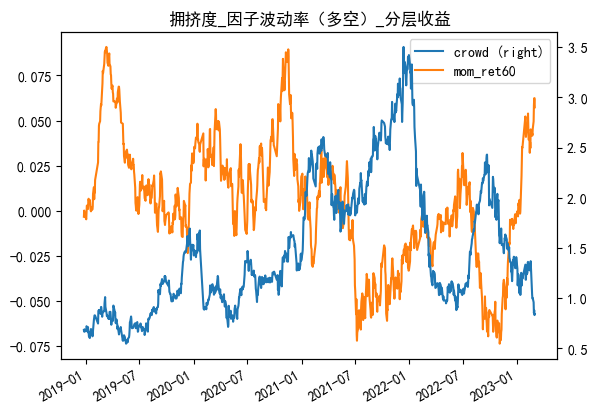

In [164]:
df[['crowd','mom_ret60']].plot(secondary_y='crowd',title = '拥挤度_因子波动率（多空）_分层收益')

<AxesSubplot: title={'center': '拥挤度_因子波动率（多空）_分层收益'}, xlabel='crowd_group'>

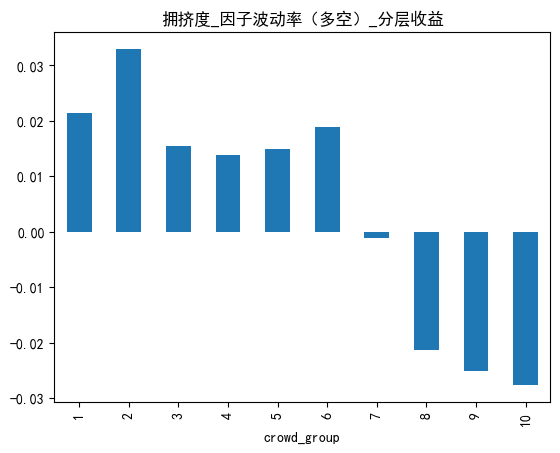

In [163]:
g = 10
df['crowd_group'] = pd.qcut(df.crowd,g, list(range(1,g+1))).to_list()
df.groupby(['crowd_group']).mom_ret60.mean().plot(kind = 'bar',title = '拥挤度_因子波动率（多空）_分层收益')

##### （3.1） 动态多空组合

In [ ]:
# 动态
std_dict = {}

for i in tqdm(date_list):
    start_date_temp = get_previous_trading_date(i,60)
    end_date_temp = i
    # 多头组波动率
    momentum_top_temp = momentum_top.loc[start_date_temp:end_date_temp]
    top_ret60 = ret.mask(momentum_top_temp.isnull())
    top_ret60_std = top_ret60.mean(axis = 1).dropna().std()
    # 空头组波动率
    momentum_bottom_temp = momentum_bottom.loc[start_date_temp:end_date_temp]
    bottom_ret60 = ret.mask(momentum_bottom_temp.isnull())
    top_bottom_ret60_std = (top_ret60.mean(axis = 1) - bottom_ret60.mean(axis = 1)).std()
    # 市场组合收益率
    stock_list_temp = momentum.loc[i].dropna().index.tolist()
    ret60 = ret.loc[start_date_temp:end_date_temp][stock_list_temp]
    ret60_std = ret60.mean(axis = 1).std()

    std_dict[i] = {'top':top_ret60_std/ret60_std,'top_bottom':top_bottom_ret60_std/ret60_std}

In [243]:
std_df = pd.DataFrame(std_dict).T
std_top = std_df['top']


std_z60 = ((std_top - std_top.rolling(60).mean())/std_top.rolling(60).std())
std_z120 = ((std_top - std_top.rolling(120).mean())/std_top.rolling(120).std())
std_z240 = ((std_top - std_top.rolling(240).mean())/std_top.rolling(240).std())
mon_cumret = (barra_return['momentum']+1).cumprod()
mom_ret20 = barra_return['momentum'].rolling(20).sum().shift(-20)
mom_ret60 = barra_return['momentum'].rolling(60).sum().shift(-60)

df = pd.concat([std_top.to_frame('crowd'),std_z60.to_frame('crowd_z60'),std_z120.to_frame('crowd_z120'),std_z240.to_frame('crowd_z240'),mon_cumret.to_frame('mon_cumret'),mom_ret20.to_frame('mom_ret20'),mom_ret60.to_frame('mom_ret60')],axis = 1).dropna()

df.corr()

,crowd,crowd_z60,crowd_z120,crowd_z240,mon_cumret,mom_ret20,mom_ret60
crowd,1.000000,0.263599,0.384377,0.553311,0.815861,-0.193573,-0.413778
crowd_z60,0.263599,1.000000,0.815140,0.623461,0.187567,0.019366,-0.016096
crowd_z120,0.384377,0.815140,1.000000,0.839562,0.254974,0.038854,-0.056695
crowd_z240,0.553311,0.623461,0.839562,1.000000,0.494505,0.034673,-0.008832
mon_cumret,0.815861,0.187567,0.254974,0.494505,1.000000,-0.219810,-0.444493
mom_ret20,-0.193573,0.019366,0.038854,0.034673,-0.219810,1.000000,0.586555
mom_ret60,-0.413778,-0.016096,-0.056695,-0.008832,-0.444493,0.586555,1.000000


<AxesSubplot: title={'center': '拥挤度_因子波动率（多空）_分层收益'}>

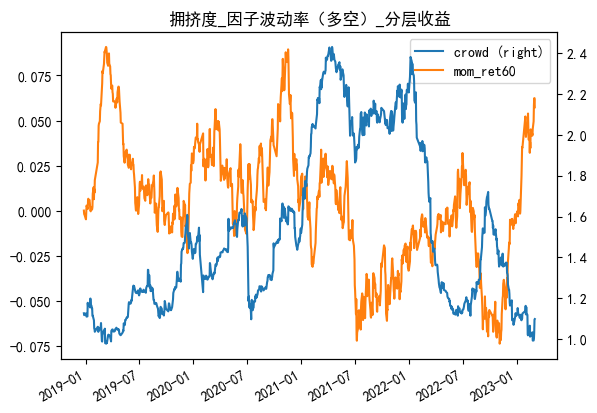

In [244]:
df[['crowd','mom_ret60']].plot(secondary_y='crowd',title = '拥挤度_因子波动率（多空）_分层收益')

<AxesSubplot: title={'center': '拥挤度_因子波动率（多头）_分层收益'}, xlabel='crowd_group'>

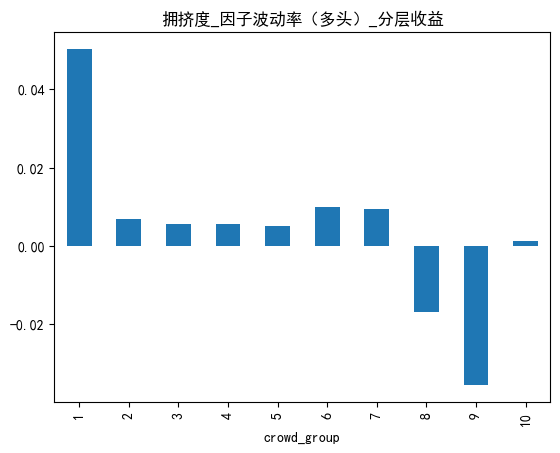

In [245]:
g = 10
df['crowd_group'] = pd.qcut(df.crowd,g, list(range(1,g+1))).to_list()
df.groupby(['crowd_group']).mom_ret60.mean().plot(kind = 'bar',title = '拥挤度_因子波动率（多头）_分层收益')

In [246]:
std_df = pd.DataFrame(std_dict).T
std_top_bottom = std_df['top_bottom']


std_z60 = ((std_top_bottom - std_top_bottom.rolling(60).mean())/std_top_bottom.rolling(60).std())
std_z120 = ((std_top_bottom - std_top_bottom.rolling(120).mean())/std_top_bottom.rolling(120).std())
std_z240 = ((std_top_bottom - std_top_bottom.rolling(240).mean())/std_top_bottom.rolling(240).std())
mon_cumret = (barra_return['momentum']+1).cumprod()
mom_ret20 = barra_return['momentum'].rolling(20).sum().shift(-20)
mom_ret60 = barra_return['momentum'].rolling(60).sum().shift(-60)

df = pd.concat([std_top_bottom.to_frame('crowd'),std_z60.to_frame('crowd_z60'),std_z120.to_frame('crowd_z120'),std_z240.to_frame('crowd_z240'),mon_cumret.to_frame('mon_cumret'),mom_ret20.to_frame('mom_ret20'),mom_ret60.to_frame('mom_ret60')],axis = 1).dropna()

df.corr()

,crowd,crowd_z60,crowd_z120,crowd_z240,mon_cumret,mom_ret20,mom_ret60
crowd,1.000000,0.172480,0.448328,0.560926,0.635089,-0.323353,-0.532189
crowd_z60,0.172480,1.000000,0.765777,0.563099,0.135515,-0.105241,-0.038721
crowd_z120,0.448328,0.765777,1.000000,0.834075,0.292185,-0.090361,-0.100675
crowd_z240,0.560926,0.563099,0.834075,1.000000,0.487641,-0.075824,-0.096027
mon_cumret,0.635089,0.135515,0.292185,0.487641,1.000000,-0.219810,-0.444493
mom_ret20,-0.323353,-0.105241,-0.090361,-0.075824,-0.219810,1.000000,0.586555
mom_ret60,-0.532189,-0.038721,-0.100675,-0.096027,-0.444493,0.586555,1.000000


<AxesSubplot: title={'center': '拥挤度_因子波动率（多空）_分层收益'}>

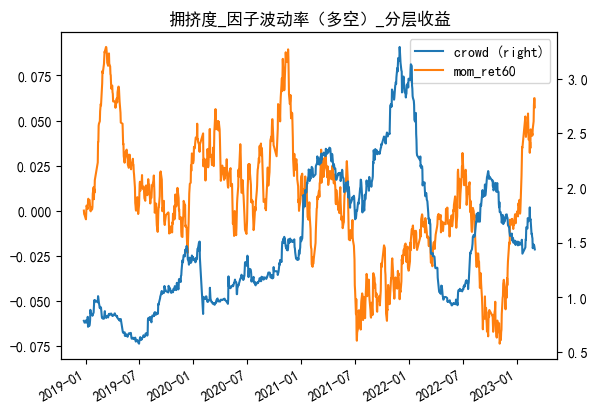

In [247]:
df[['crowd','mom_ret60']].plot(secondary_y='crowd',title = '拥挤度_因子波动率（多空）_分层收益')

<AxesSubplot: title={'center': '拥挤度_因子波动率（多空）_分层收益'}, xlabel='crowd_group'>

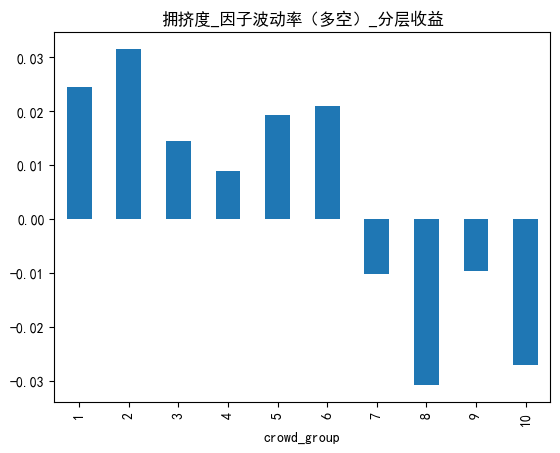

In [248]:
g = 10
df['crowd_group'] = pd.qcut(df.crowd,g, list(range(1,g+1))).to_list()
df.groupby(['crowd_group']).mom_ret60.mean().plot(kind = 'bar',title = '拥挤度_因子波动率（多空）_分层收益')

##### （4）因子反转

De Bondt等(1985) 表明美股在 3 到 5 年的中长期尺度上存在反转。由于投资者有追逐过去业绩的倾向，一个在一段时间内表现良好的因子可能已经积累了大量资本。这种性能追逐最初可能会为因子性能提供顺风，但最终可能会为视图或位置改变时的下降或均值回归奠定基础。异常强劲的表现通常不会永远持续下去。本文使用因子过去三年的累积收益率计算该指标。

+ 因子长期反转=Ret（因子多空组合近三年）

In [249]:
ret = get_price(stock_list,get_previous_trading_date(start_date,252*3),end_date,fields = 'close').close.unstack('order_book_id').pct_change().dropna(how = 'all')

In [170]:
momentum = barra_dict[barra_style[0]].mask(~index_fix)
momentum_top = momentum.mask((momentum.sub(momentum.quantile(0.9,axis = 1),axis = 0)) < 0)
momentum_bottom = momentum.mask(momentum.sub(momentum.quantile(0.1,axis = 1),axis = 0) > 0)

In [251]:
turn_dict = {}

for i in tqdm(date_list):
    start_date_temp = get_previous_trading_date(i,252*3)
    end_date_temp = i
    # 多头组波动率
    stock_list_top_temp = momentum_top.loc[i].dropna().index.tolist()
    top_ret756 = ret.loc[start_date_temp:end_date_temp][stock_list_top_temp]
    # 空头组波动率
    stock_list_bottom_temp = momentum_bottom.loc[i].dropna().index.tolist()
    bottom_ret756 = ret.loc[start_date_temp:end_date_temp][stock_list_bottom_temp]
    top_ret756_value = (top_ret756.mean(axis = 1) + 1).cumprod()[-1] - 1
    top_bottom_ret756 = ((top_ret756.mean(axis = 1) - bottom_ret756.mean(axis = 1)) + 1).cumprod()[-1] - 1

    turn_dict[i] = {'top':top_ret756_value,'top_bottom':top_bottom_ret756}

100%|██████████| 1314/1314 [00:03<00:00, 337.81it/s]


In [252]:
turn_df = pd.DataFrame(turn_dict).T
turn_top_bottom = turn_df['top_bottom']


turn_z60 = ((turn_top_bottom - turn_top_bottom.rolling(60).mean())/turn_top_bottom.rolling(60).std())
turn_z120 = ((turn_top_bottom - turn_top_bottom.rolling(120).mean())/turn_top_bottom.rolling(120).std())
turn_z240 = ((turn_top_bottom - turn_top_bottom.rolling(240).mean())/turn_top_bottom.rolling(240).std())
mon_cumret = (barra_return['momentum']+1).cumprod()
mom_ret20 = barra_return['momentum'].rolling(20).sum().shift(-20)
mom_ret60 = barra_return['momentum'].rolling(60).sum().shift(-60)

df = pd.concat([turn_top_bottom.to_frame('crowd'),turn_z60.to_frame('crowd_z60'),turn_z120.to_frame('crowd_z120'),turn_z240.to_frame('crowd_z240'),mon_cumret.to_frame('mon_cumret'),mom_ret20.to_frame('mom_ret20'),mom_ret60.to_frame('mom_ret60')],axis = 1).dropna()

df.corr()

,crowd,crowd_z60,crowd_z120,crowd_z240,mon_cumret,mom_ret20,mom_ret60
crowd,1.000000,0.429382,0.500457,0.672356,0.590705,-0.001862,-0.084458
crowd_z60,0.429382,1.000000,0.880009,0.703077,0.016876,0.040082,-0.049237
crowd_z120,0.500457,0.880009,1.000000,0.867442,-0.026276,-0.005913,-0.125227
crowd_z240,0.672356,0.703077,0.867442,1.000000,-0.001222,0.005891,-0.019239
mon_cumret,0.590705,0.016876,-0.026276,-0.001222,1.000000,-0.220319,-0.443381
mom_ret20,-0.001862,0.040082,-0.005913,0.005891,-0.220319,1.000000,0.586361
mom_ret60,-0.084458,-0.049237,-0.125227,-0.019239,-0.443381,0.586361,1.000000


<AxesSubplot: title={'center': '拥挤度_因子反转（多空）_分层收益'}>

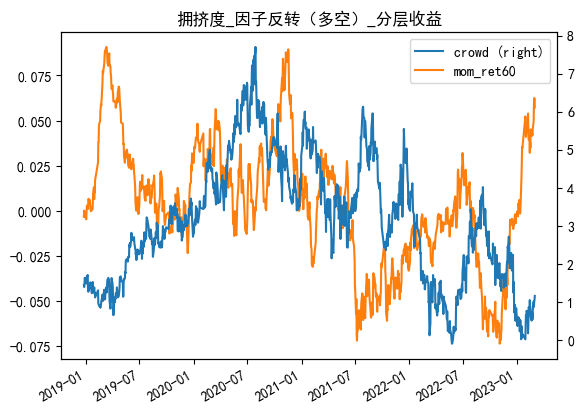

In [253]:
df[['crowd','mom_ret60']].plot(secondary_y='crowd',title = '拥挤度_因子反转（多空）_分层收益')

<AxesSubplot: title={'center': '拥挤度_因子波动率（多空）_分层收益'}, xlabel='crowd_group'>

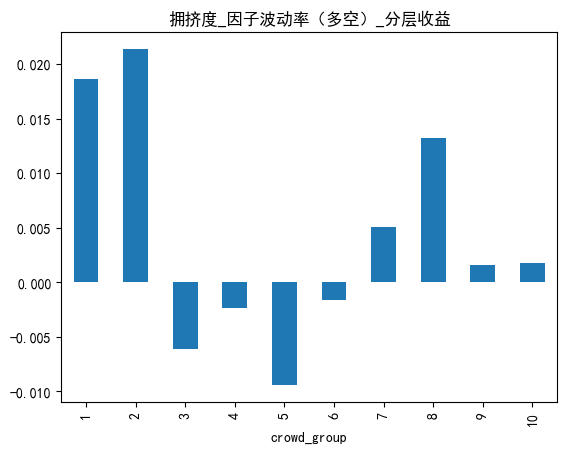

In [254]:
g = 10
df['crowd_group'] = pd.qcut(df.crowd,g, list(range(1,g+1))).to_list()
df.groupby(['crowd_group']).mom_ret60.mean().plot(kind = 'bar',title = '拥挤度_因子波动率（多空）_分层收益')

In [255]:
turn_df = pd.DataFrame(turn_dict).T
turn_top = turn_df['top']


turn_z60 = ((turn_top - turn_top.rolling(60).mean())/turn_top.rolling(60).std())
turn_z120 = ((turn_top - turn_top.rolling(120).mean())/turn_top.rolling(120).std())
turn_z240 = ((turn_top - turn_top.rolling(240).mean())/turn_top.rolling(240).std())
mon_cumret = (barra_return['momentum']+1).cumprod()
mom_ret20 = barra_return['momentum'].rolling(20).sum().shift(-20)
mom_ret60 = barra_return['momentum'].rolling(60).sum().shift(-60)

df = pd.concat([turn_top.to_frame('crowd'),turn_z60.to_frame('crowd_z60'),turn_z120.to_frame('crowd_z120'),turn_z240.to_frame('crowd_z240'),mon_cumret.to_frame('mon_cumret'),mom_ret20.to_frame('mom_ret20'),mom_ret60.to_frame('mom_ret60')],axis = 1).dropna()

df.corr()

,crowd,crowd_z60,crowd_z120,crowd_z240,mon_cumret,mom_ret20,mom_ret60
crowd,1.000000,0.310636,0.406059,0.456308,0.631619,-0.199333,-0.484114
crowd_z60,0.310636,1.000000,0.875701,0.700944,0.013256,0.110282,0.079913
crowd_z120,0.406059,0.875701,1.000000,0.894117,0.033400,0.064737,-0.012432
crowd_z240,0.456308,0.700944,0.894117,1.000000,0.107712,0.060089,-0.021435
mon_cumret,0.631619,0.013256,0.033400,0.107712,1.000000,-0.220319,-0.443381
mom_ret20,-0.199333,0.110282,0.064737,0.060089,-0.220319,1.000000,0.586361
mom_ret60,-0.484114,0.079913,-0.012432,-0.021435,-0.443381,0.586361,1.000000


<AxesSubplot: title={'center': '拥挤度_因子反转（多空）_分层收益'}>

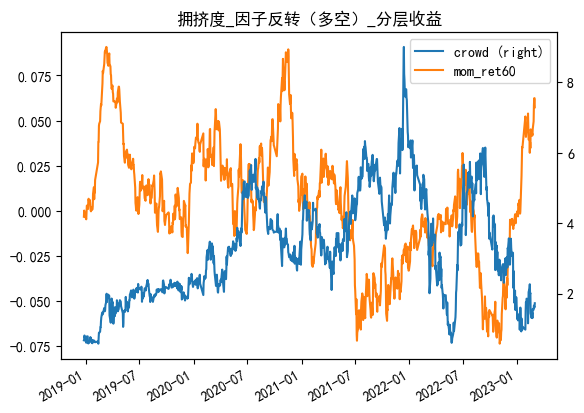

In [256]:
df[['crowd','mom_ret60']].plot(secondary_y='crowd',title = '拥挤度_因子反转（多空）_分层收益')

<AxesSubplot: title={'center': '拥挤度_因子波动率（多空）_分层收益'}, xlabel='crowd_group'>

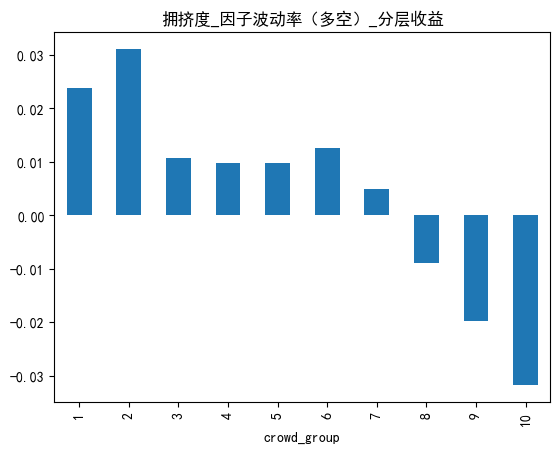

In [257]:
g = 10
df['crowd_group'] = pd.qcut(df.crowd,g, list(range(1,g+1))).to_list()
df.groupby(['crowd_group']).mom_ret60.mean().plot(kind = 'bar',title = '拥挤度_因子波动率（多空）_分层收益')

##### （4.1） 动态多空组合

In [278]:
turn_dict = {}

for i in tqdm(date_list[252*3:]):
    start_date_temp = get_previous_trading_date(i,252*3)
    end_date_temp = i
    # 多头组波动率
    momentum_top_temp = momentum_top.loc[start_date_temp:end_date_temp]
    momentum_bottom_temp = momentum_bottom.loc[start_date_temp:end_date_temp]

    top_ret756_value = (ret.mask(momentum_top_temp.isnull()).mean(axis = 1).dropna() + 1).cumprod()[-1] - 1
    top_bottom_ret756 = ret.mask(momentum_top_temp.isnull()).mean(axis = 1) - ret.mask(momentum_bottom_temp.isnull()).mean(axis = 1)

    turn_dict[i] = {'top':top_ret756_value,'top_bottom':((top_bottom_ret756.dropna() + 1).cumprod()[-1] - 1)}

100%|██████████| 558/558 [06:00<00:00,  1.55it/s]


In [279]:
turn_df = pd.DataFrame(turn_dict).T
turn_top = turn_df['top']


turn_z60 = ((turn_top - turn_top.rolling(60).mean())/turn_top.rolling(60).std())
turn_z120 = ((turn_top - turn_top.rolling(120).mean())/turn_top.rolling(120).std())
turn_z240 = ((turn_top - turn_top.rolling(240).mean())/turn_top.rolling(240).std())
mon_cumret = (barra_return['momentum']+1).cumprod()
mom_ret20 = barra_return['momentum'].rolling(20).sum().shift(-20)
mom_ret60 = barra_return['momentum'].rolling(60).sum().shift(-60)

df = pd.concat([turn_top.to_frame('crowd'),turn_z60.to_frame('crowd_z60'),turn_z120.to_frame('crowd_z120'),turn_z240.to_frame('crowd_z240'),mon_cumret.to_frame('mon_cumret'),mom_ret20.to_frame('mom_ret20'),mom_ret60.to_frame('mom_ret60')],axis = 1).dropna()

df.corr()

,crowd,crowd_z60,crowd_z120,crowd_z240,mon_cumret,mom_ret20,mom_ret60
crowd,1.000000,0.212207,0.205034,0.579299,0.709291,0.232328,-0.040428
crowd_z60,0.212207,1.000000,0.860617,0.356855,-0.082550,0.262854,0.373825
crowd_z120,0.205034,0.860617,1.000000,0.541585,-0.127711,0.399745,0.295819
crowd_z240,0.579299,0.356855,0.541585,1.000000,0.101109,0.085680,-0.001178
mon_cumret,0.709291,-0.082550,-0.127711,0.101109,1.000000,-0.143256,-0.563487
mom_ret20,0.232328,0.262854,0.399745,0.085680,-0.143256,1.000000,0.571185
mom_ret60,-0.040428,0.373825,0.295819,-0.001178,-0.563487,0.571185,1.000000


<AxesSubplot: title={'center': '拥挤度_因子反转（多头）_分层收益'}>

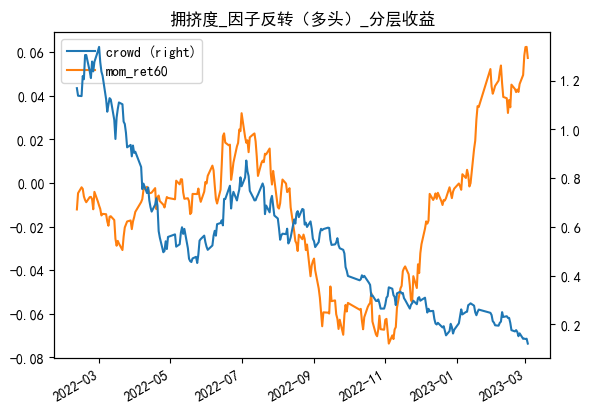

In [280]:
df[['crowd','mom_ret60']].plot(secondary_y='crowd',title = '拥挤度_因子反转（多头）_分层收益')

<AxesSubplot: title={'center': '拥挤度_因子波动率（多头）_分层收益'}, xlabel='crowd_group'>

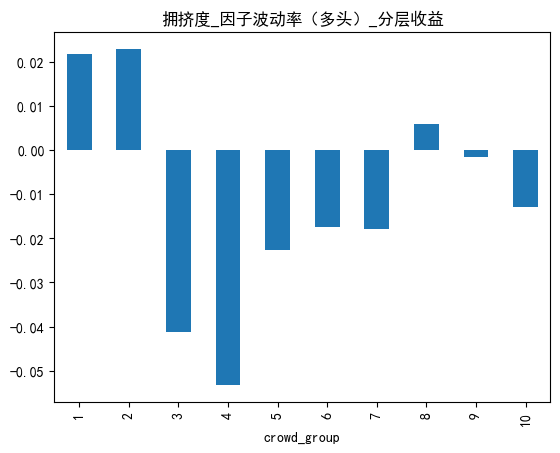

In [281]:
g = 10
df['crowd_group'] = pd.qcut(df.crowd,g, list(range(1,g+1))).to_list()
df.groupby(['crowd_group']).mom_ret60.mean().plot(kind = 'bar',title = '拥挤度_因子波动率（多头）_分层收益')

In [204]:
turn_df = pd.DataFrame(turn_dict).T
turn_top_bottom = turn_df['top_bottom']


turn_z60 = ((turn_top_bottom - turn_top_bottom.rolling(60).mean())/turn_top_bottom.rolling(60).std())
turn_z120 = ((turn_top_bottom - turn_top_bottom.rolling(120).mean())/turn_top_bottom.rolling(120).std())
turn_z240 = ((turn_top_bottom - turn_top_bottom.rolling(240).mean())/turn_top_bottom.rolling(240).std())
mon_cumret = (barra_return['momentum']+1).cumprod()
mom_ret20 = barra_return['momentum'].rolling(20).sum().shift(-20)
mom_ret60 = barra_return['momentum'].rolling(60).sum().shift(-60)

df = pd.concat([turn_top_bottom.to_frame('crowd'),turn_z60.to_frame('crowd_z60'),turn_z120.to_frame('crowd_z120'),turn_z240.to_frame('crowd_z240'),mon_cumret.to_frame('mon_cumret'),mom_ret20.to_frame('mom_ret20'),mom_ret60.to_frame('mom_ret60')],axis = 1).dropna()

df.corr()

,crowd,crowd_z60,crowd_z120,crowd_z240,mon_cumret,mom_ret20,mom_ret60
crowd,1.000000,0.669704,0.745051,0.717174,0.827437,0.073900,-0.169710
crowd_z60,0.669704,1.000000,0.887896,0.898053,0.375367,0.124492,-0.025414
crowd_z120,0.745051,0.887896,1.000000,0.983242,0.452858,-0.038955,-0.109570
crowd_z240,0.717174,0.898053,0.983242,1.000000,0.360853,-0.004943,-0.003511
mon_cumret,0.827437,0.375367,0.452858,0.360853,1.000000,-0.143256,-0.563487
mom_ret20,0.073900,0.124492,-0.038955,-0.004943,-0.143256,1.000000,0.571185
mom_ret60,-0.169710,-0.025414,-0.109570,-0.003511,-0.563487,0.571185,1.000000


<AxesSubplot: title={'center': '拥挤度_因子反转（多空）_分层收益'}>

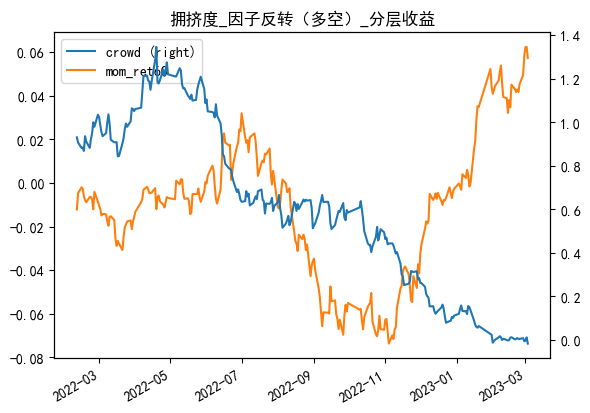

In [208]:
df[['crowd','mom_ret60']].plot(secondary_y='crowd',title = '拥挤度_因子反转（多空）_分层收益')

<AxesSubplot: title={'center': '拥挤度_因子波动率（多空）_分层收益'}, xlabel='crowd_group'>

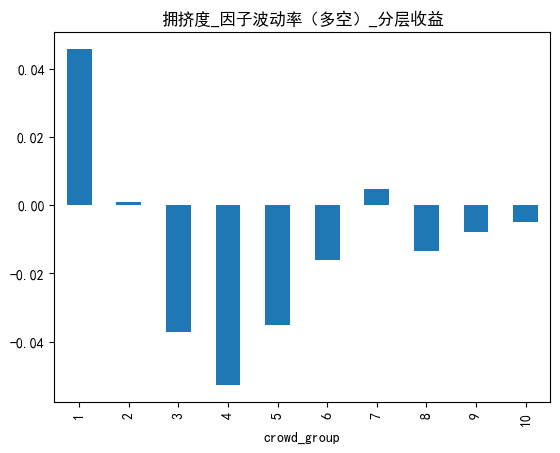

In [209]:
g = 10
df['crowd_group'] = pd.qcut(df.crowd,g, list(range(1,g+1))).to_list()
df.groupby(['crowd_group']).mom_ret60.mean().plot(kind = 'bar',title = '拥挤度_因子波动率（多空）_分层收益')

In [211]:
turn_dict = {}

for i in tqdm(date_list[252*1:]):
    start_date_temp = get_previous_trading_date(i,252*1)
    end_date_temp = i
    # 多头组波动率
    momentum_top_temp = momentum_top.loc[start_date_temp:end_date_temp]
    momentum_bottom_temp = momentum_bottom.loc[start_date_temp:end_date_temp]
    top_bottom_ret250 = ret.mask(momentum_top_temp.isnull()).mean(axis = 1) - ret.mask(momentum_bottom_temp.isnull()).mean(axis = 1)

    turn_dict[i] = {'top_bottom':((top_bottom_ret250.dropna() + 1).cumprod()[-1] - 1)}

100%|██████████| 1062/1062 [06:52<00:00,  2.58it/s]


In [212]:
turn_df = pd.DataFrame(turn_dict).T
turn_top_bottom = turn_df['top_bottom']


turn_z60 = ((turn_top_bottom - turn_top_bottom.rolling(60).mean())/turn_top_bottom.rolling(60).std())
turn_z120 = ((turn_top_bottom - turn_top_bottom.rolling(120).mean())/turn_top_bottom.rolling(120).std())
turn_z240 = ((turn_top_bottom - turn_top_bottom.rolling(240).mean())/turn_top_bottom.rolling(240).std())
mon_cumret = (barra_return['momentum']+1).cumprod()
mom_ret20 = barra_return['momentum'].rolling(20).sum().shift(-20)
mom_ret60 = barra_return['momentum'].rolling(60).sum().shift(-60)

df = pd.concat([turn_top_bottom.to_frame('crowd'),turn_z60.to_frame('crowd_z60'),turn_z120.to_frame('crowd_z120'),turn_z240.to_frame('crowd_z240'),mon_cumret.to_frame('mon_cumret'),mom_ret20.to_frame('mom_ret20'),mom_ret60.to_frame('mom_ret60')],axis = 1).dropna()

df.corr()

,crowd,crowd_z60,crowd_z120,crowd_z240,mon_cumret,mom_ret20,mom_ret60
crowd,1.000000,0.406572,0.563989,0.723545,0.721821,0.107015,0.183748
crowd_z60,0.406572,1.000000,0.880986,0.729428,0.092203,-0.087200,0.087485
crowd_z120,0.563989,0.880986,1.000000,0.905753,0.134726,-0.016371,0.205578
crowd_z240,0.723545,0.729428,0.905753,1.000000,0.213133,0.118205,0.319533
mon_cumret,0.721821,0.092203,0.134726,0.213133,1.000000,-0.124176,-0.273850
mom_ret20,0.107015,-0.087200,-0.016371,0.118205,-0.124176,1.000000,0.569990
mom_ret60,0.183748,0.087485,0.205578,0.319533,-0.273850,0.569990,1.000000


<AxesSubplot: title={'center': '拥挤度_因子反转（多空）_分层收益'}>

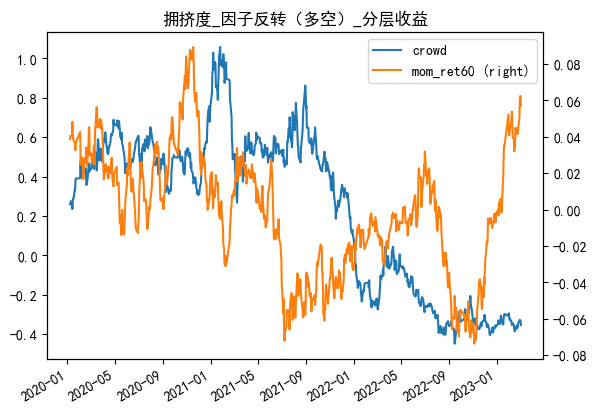

In [217]:
df[['crowd','mom_ret60']].plot(secondary_y='mom_ret60',title = '拥挤度_因子反转（多空）_分层收益')

<AxesSubplot: title={'center': '拥挤度_因子波动率（多空）_分层收益'}, xlabel='crowd'>

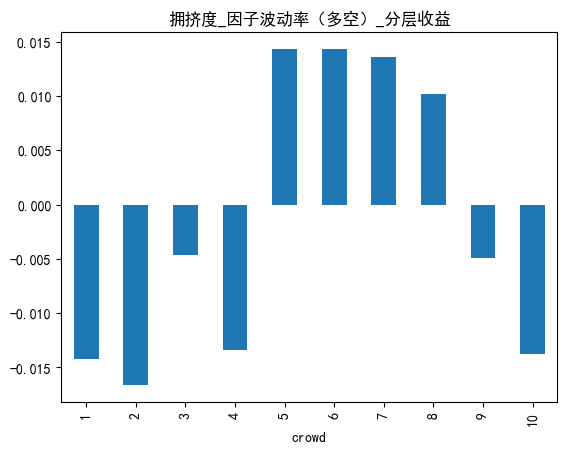

In [221]:
g = 10
df['crowd'] = pd.qcut(df.crowd,g, list(range(1,g+1))).to_list()
df.groupby(['crowd']).mom_ret60.mean().plot(kind = 'bar',title = '拥挤度_因子波动率（多空）_分层收益')

##### （4.2）一年期

In [260]:
turn_dict = {}

for i in tqdm(date_list):
    start_date_temp = get_previous_trading_date(i,252)
    end_date_temp = i
    # 多头组波动率
    stock_list_top_temp = momentum_top.loc[i].dropna().index.tolist()
    top_ret756 = ret.loc[start_date_temp:end_date_temp][stock_list_top_temp]
    # 空头组波动率
    stock_list_bottom_temp = momentum_bottom.loc[i].dropna().index.tolist()
    bottom_ret756 = ret.loc[start_date_temp:end_date_temp][stock_list_bottom_temp]
    top_ret756_value = (top_ret756.mean(axis = 1) + 1).cumprod()[-1] - 1
    top_bottom_ret756 = ((top_ret756.mean(axis = 1) - bottom_ret756.mean(axis = 1)) + 1).cumprod()[-1] - 1

    turn_dict[i] = {'top':top_ret756_value,'top_bottom':top_bottom_ret756}

100%|██████████| 1314/1314 [00:03<00:00, 433.02it/s]


In [261]:
turn_df = pd.DataFrame(turn_dict).T
turn_top_bottom = turn_df['top_bottom']


turn_z60 = ((turn_top_bottom - turn_top_bottom.rolling(60).mean())/turn_top_bottom.rolling(60).std())
turn_z120 = ((turn_top_bottom - turn_top_bottom.rolling(120).mean())/turn_top_bottom.rolling(120).std())
turn_z240 = ((turn_top_bottom - turn_top_bottom.rolling(240).mean())/turn_top_bottom.rolling(240).std())
mon_cumret = (barra_return['momentum']+1).cumprod()
mom_ret20 = barra_return['momentum'].rolling(20).sum().shift(-20)
mom_ret60 = barra_return['momentum'].rolling(60).sum().shift(-60)

df = pd.concat([turn_top_bottom.to_frame('crowd'),turn_z60.to_frame('crowd_z60'),turn_z120.to_frame('crowd_z120'),turn_z240.to_frame('crowd_z240'),mon_cumret.to_frame('mon_cumret'),mom_ret20.to_frame('mom_ret20'),mom_ret60.to_frame('mom_ret60')],axis = 1).dropna()

df.corr()

,crowd,crowd_z60,crowd_z120,crowd_z240,mon_cumret,mom_ret20,mom_ret60
crowd,1.000000,0.430962,0.531108,0.699991,0.856692,-0.195039,-0.343217
crowd_z60,0.430962,1.000000,0.892233,0.727337,0.264308,-0.047370,-0.013354
crowd_z120,0.531108,0.892233,1.000000,0.889415,0.334384,-0.044741,0.021799
crowd_z240,0.699991,0.727337,0.889415,1.000000,0.554280,-0.043830,-0.053398
mon_cumret,0.856692,0.264308,0.334384,0.554280,1.000000,-0.220319,-0.443381
mom_ret20,-0.195039,-0.047370,-0.044741,-0.043830,-0.220319,1.000000,0.586361
mom_ret60,-0.343217,-0.013354,0.021799,-0.053398,-0.443381,0.586361,1.000000


<AxesSubplot: title={'center': '拥挤度_因子反转（多空）_分层收益'}>

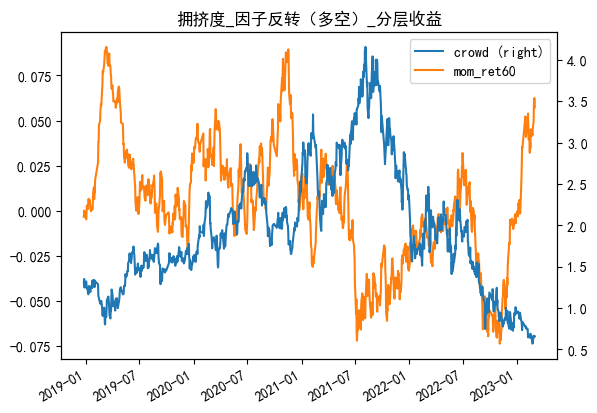

In [262]:
df[['crowd','mom_ret60']].plot(secondary_y='crowd',title = '拥挤度_因子反转（多空）_分层收益')

<AxesSubplot: title={'center': '拥挤度_因子波动率（多空）_分层收益'}, xlabel='crowd_group'>

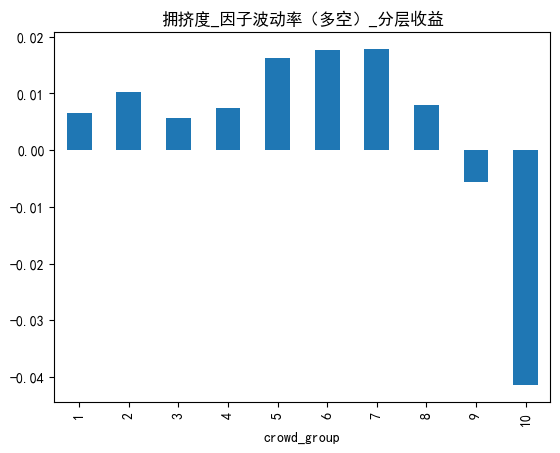

In [263]:
g = 10
df['crowd_group'] = pd.qcut(df.crowd,g, list(range(1,g+1))).to_list()
df.groupby(['crowd_group']).mom_ret60.mean().plot(kind = 'bar',title = '拥挤度_因子波动率（多空）_分层收益')

In [264]:
turn_df = pd.DataFrame(turn_dict).T
turn_top = turn_df['top']


turn_z60 = ((turn_top - turn_top.rolling(60).mean())/turn_top.rolling(60).std())
turn_z120 = ((turn_top - turn_top.rolling(120).mean())/turn_top.rolling(120).std())
turn_z240 = ((turn_top - turn_top.rolling(240).mean())/turn_top.rolling(240).std())
mon_cumret = (barra_return['momentum']+1).cumprod()
mom_ret20 = barra_return['momentum'].rolling(20).sum().shift(-20)
mom_ret60 = barra_return['momentum'].rolling(60).sum().shift(-60)

df = pd.concat([turn_top.to_frame('crowd'),turn_z60.to_frame('crowd_z60'),turn_z120.to_frame('crowd_z120'),turn_z240.to_frame('crowd_z240'),mon_cumret.to_frame('mon_cumret'),mom_ret20.to_frame('mom_ret20'),mom_ret60.to_frame('mom_ret60')],axis = 1).dropna()

df.corr()

,crowd,crowd_z60,crowd_z120,crowd_z240,mon_cumret,mom_ret20,mom_ret60
crowd,1.000000,0.241825,0.325672,0.550249,0.768215,0.018748,-0.022951
crowd_z60,0.241825,1.000000,0.844664,0.698498,-0.168818,0.174886,0.312317
crowd_z120,0.325672,0.844664,1.000000,0.886444,-0.162968,0.194794,0.395496
crowd_z240,0.550249,0.698498,0.886444,1.000000,0.078685,0.173942,0.288467
mon_cumret,0.768215,-0.168818,-0.162968,0.078685,1.000000,-0.220319,-0.443381
mom_ret20,0.018748,0.174886,0.194794,0.173942,-0.220319,1.000000,0.586361
mom_ret60,-0.022951,0.312317,0.395496,0.288467,-0.443381,0.586361,1.000000


<AxesSubplot: title={'center': '拥挤度_因子反转（多空）_分层收益'}>

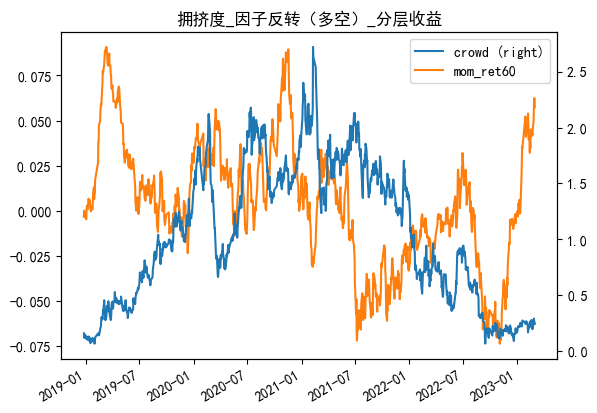

In [265]:
df[['crowd','mom_ret60']].plot(secondary_y='crowd',title = '拥挤度_因子反转（多空）_分层收益')

<AxesSubplot: title={'center': '拥挤度_因子波动率（多空）_分层收益'}, xlabel='crowd_group'>

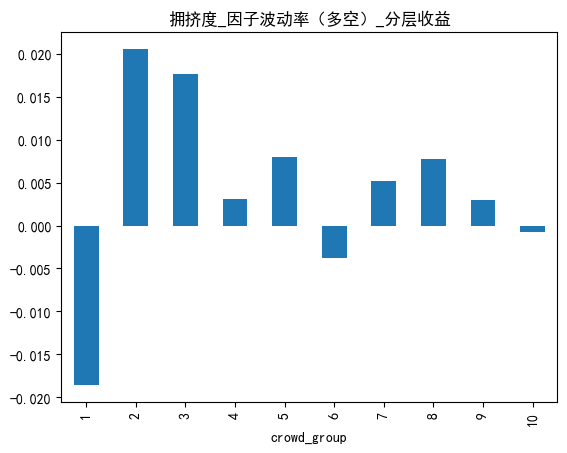

In [266]:
g = 10
df['crowd_group'] = pd.qcut(df.crowd,g, list(range(1,g+1))).to_list()
df.groupby(['crowd_group']).mom_ret60.mean().plot(kind = 'bar',title = '拥挤度_因子波动率（多空）_分层收益')

### 拥挤度指标汇总

In [9]:
def Valuation_spread(factor):
    factor = factor.mask(~index_fix)
    factor_top = factor.mask((factor.sub(factor.quantile(0.9,axis = 1),axis = 0)) < 0)
    factor_bottom = factor.mask(factor.sub(factor.quantile(0.1,axis = 1),axis = 0) > 0)
    # 估值因子
    bp = execute_factor(Factor('book_to_market_ratio_lf'),stock_list,start_date,end_date).mask(~index_fix)

    bp_spread = bp.mask(factor_top.isnull()).median(axis = 1) - bp.mask(factor_bottom.isnull()).median(axis = 1)

    return bp_spread

def Pairwise(factor):
    ret = get_price(stock_list,get_previous_trading_date(start_date,60),end_date,fields = 'close').close.unstack('order_book_id').pct_change().dropna(how = 'all')
    
    factor = factor.mask(~index_fix)
    factor_top = factor.mask((factor.sub(factor.quantile(0.9,axis = 1),axis = 0)) < 0)
    factor_bottom = factor.mask(factor.sub(factor.quantile(0.1,axis = 1),axis = 0) > 0)

    match_dict = {}

    for i in tqdm(date_list):
        start_date_temp = get_previous_trading_date(i,60)
        end_date_temp = i
        # 多头组配对相关性
        stock_list_top_temp = factor_top.loc[i].dropna().index.tolist()
        top_ret60 = ret.loc[start_date_temp:end_date_temp][stock_list_top_temp]
        top_ret60['mean'] = top_ret60.mean(axis = 1)
        top_match = top_ret60.corr()['mean'].drop('mean').mean()
        # 空头组配对相关性
        stock_list_bottom_temp = factor_bottom.loc[i].dropna().index.tolist()
        bottom_ret60 = ret.loc[start_date_temp:end_date_temp][stock_list_bottom_temp]
        bottom_ret60['mean'] = bottom_ret60.mean(axis = 1)
        bottom_match = bottom_ret60.corr()['mean'].drop('mean').mean()

        match_dict[i] = {'top':top_match,'bottom':bottom_match}

    match_df = pd.DataFrame(match_dict).T
    match_df['match'] = match_df['top'] + match_df['bottom']
    match_top_bottom = - match_df['match']
    match_top = - match_df['top']
    match_bottom = - match_df['bottom']

    return match_top_bottom,match_top,match_bottom

def Volatility(factor):
    ret = get_price(stock_list,get_previous_trading_date(start_date,60),end_date,fields = 'close').close.unstack('order_book_id').pct_change().dropna(how = 'all')
    
    factor = factor.mask(~index_fix)
    factor_top = factor.mask((factor.sub(factor.quantile(0.9,axis = 1),axis = 0)) < 0)
    factor_bottom = factor.mask(factor.sub(factor.quantile(0.1,axis = 1),axis = 0) > 0)

    std_dict = {}

    for i in tqdm(date_list):
        start_date_temp = get_previous_trading_date(i,60)
        end_date_temp = i
        # 多头组波动率
        stock_list_top_temp = factor_top.loc[i].dropna().index.tolist()
        top_ret60 = ret.loc[start_date_temp:end_date_temp][stock_list_top_temp]
        top_ret60_std = top_ret60.mean(axis = 1).std()
        # 空头组波动率
        stock_list_bottom_temp = factor_bottom.loc[i].dropna().index.tolist()
        bottom_ret60 = ret.loc[start_date_temp:end_date_temp][stock_list_bottom_temp]
        top_bottom_ret60_std = (top_ret60.mean(axis = 1) - bottom_ret60.mean(axis = 1)).std()
        # 市场组合收益率
        stock_list_temp = factor.loc[i].dropna().index.tolist()
        ret60 = ret.loc[start_date_temp:end_date_temp][stock_list_temp]
        ret60_std = ret60.mean(axis = 1).std()

        std_dict[i] = {'top':top_ret60_std/ret60_std,'top_bottom':top_bottom_ret60_std/ret60_std}

    std_df = pd.DataFrame(std_dict).T
    std_top = std_df['top']
    std_top_bottom = std_df['top_bottom']

    return std_top,std_top_bottom

def Reversal(factor):
    ret = get_price(stock_list,get_previous_trading_date(start_date,60),end_date,fields = 'close').close.unstack('order_book_id').pct_change().dropna(how = 'all')
    
    factor = factor.mask(~index_fix)
    factor_top = factor.mask((factor.sub(factor.quantile(0.9,axis = 1),axis = 0)) < 0)
    #factor_bottom = factor.mask(factor.sub(factor.quantile(0.1,axis = 1),axis = 0) > 0)

    turn_dict = {}

    for i in tqdm(date_list):
        start_date_temp = get_previous_trading_date(i,252*3)
        end_date_temp = i
        # 多头组波动率
        stock_list_top_temp = factor_top.loc[i].dropna().index.tolist()
        top_ret756 = ret.loc[start_date_temp:end_date_temp][stock_list_top_temp]
        # 空头组波动率
        #stock_list_bottom_temp = factor_bottom.loc[i].dropna().index.tolist()
        #bottom_ret756 = ret.loc[start_date_temp:end_date_temp][stock_list_bottom_temp]
        top_ret756_value = (top_ret756.mean(axis = 1) + 1).cumprod()[-1] - 1
        #top_bottom_ret756 = ((top_ret756.mean(axis = 1) - bottom_ret756.mean(axis = 1)) + 1).cumprod()[-1] - 1

        turn_dict[i] = {'top':top_ret756_value}

    turn_df = pd.DataFrame(turn_dict).T
    turn_top = turn_df['top']

    return turn_top

In [10]:
def crowd(factor,name):
    print('loading valuation_spread ...')
    bp_spread = Valuation_spread(factor)
    print('loading pairwise ...')
    match_top_bottom,match_top,match_bottom = Pairwise(factor)
    print('loading volatility ...')
    std_top,std_top_bottom = Volatility(factor)
    print('loading reversal ...')
    turn_top = Reversal(factor)

    factor_ret5 = barra_return[name].rolling(5).sum().shift(-5)
    factor_ret20 = barra_return[name].rolling(20).sum().shift(-20)
    factor_ret60 = barra_return[name].rolling(60).sum().shift(-60)

    df = pd.concat([bp_spread.to_frame('bp_spread'),
                    match_top_bottom.to_frame('match_top_bottom'),
                    match_top.to_frame('match_top'),
                    match_bottom.to_frame('match_bottom'),
                    std_top.to_frame('std_top'),
                    std_top_bottom.to_frame('std_top_bottom'),
                    turn_top.to_frame('turn_top'),
                    factor_ret5.to_frame('factor_ret5'),
                    factor_ret20.to_frame('factor_ret20'),
                    factor_ret60.to_frame('factor_ret60'),
                    ],axis = 1)
    
    df.columns.names = [name]
    
    return df

In [11]:
momentum = barra_dict[barra_style[0]].mask(~index_fix)

In [12]:
momentum_crowd = crowd(momentum,'momentum')

loading valuation_spread ...
loading pairwise ...


100%|██████████| 1314/1314 [00:04<00:00, 316.04it/s]


loading volatility ...


100%|██████████| 1314/1314 [00:03<00:00, 360.49it/s]


loading reversal ...


100%|██████████| 1314/1314 [00:01<00:00, 1162.80it/s]


### 原始因子合成

In [13]:
# 热力图    
def hot_corr(name,ic_df):
    """
    :param name: 因子名称 -> list 
    :param ic_df: ic序列表 -> dataframe 
    :return fig: 热力图 -> plt
    """
    ax = plt.subplots(figsize=(len(name), len(name)))#调整画布大小
    ax = sns.heatmap(ic_df[name].corr(),vmin=0.4, square=True, annot= True,cmap = 'Blues')   #annot=True 表示显示系数
    plt.title('Factors_IC_CORRELATION')
    # 设置刻度字体大小
    plt.xticks(fontsize=10)
    plt.yticks(fontsize=10)

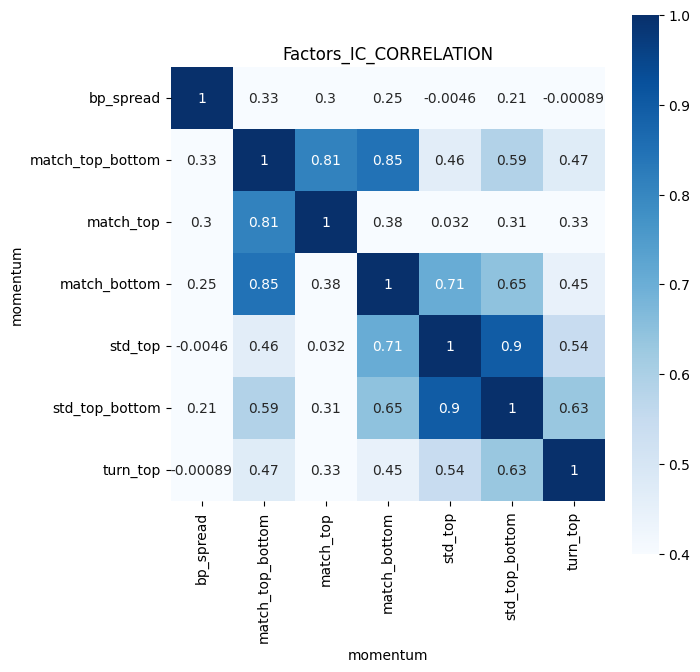

In [14]:
hot_corr(momentum_crowd.columns.tolist()[:-3],momentum_crowd)

<AxesSubplot: title={'center': 'momentum_crowd_summary'}, xlabel='momentum'>

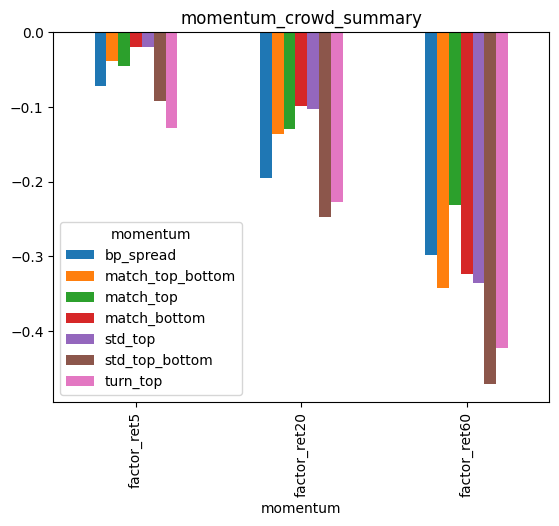

In [16]:
momentum_crowd.corr().loc[:'turn_top','factor_ret5':].T.plot(kind = 'bar',title = 'momentum_crowd_summary')

In [17]:
# 拥挤度因子时序预测相关性能力
corr_ts = momentum_crowd.dropna().rolling(240).corr().dropna()['factor_ret60'].unstack('momentum')[['bp_spread','match_bottom','match_top','match_top_bottom','std_top','std_top_bottom','turn_top']]

<AxesSubplot: >

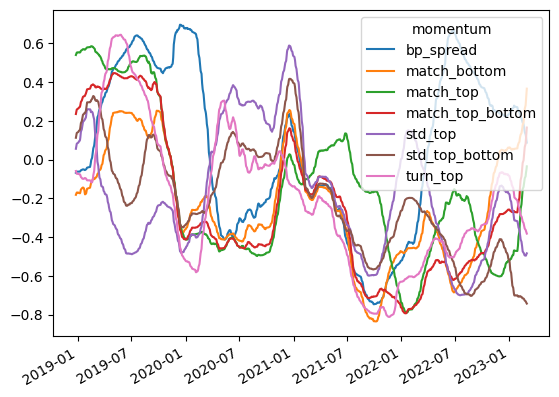

In [19]:
corr_ts.plot()

#### 动态加权合成尝试

In [20]:
factor_ret60 = barra_return['momentum'].rolling(60).sum().shift(-60)
- momentum_crowd[['bp_spread','match_bottom','match_top','match_top_bottom','std_top','std_top_bottom','turn_top']].mul(corr_ts,axis = 0).dropna().sum(axis = 1).corr(factor_ret60)

-0.5564377045937384

In [21]:
# del ['match_top_bottom','std_top']
momentum_crowd[['bp_spread','match_bottom','match_top','match_top_bottom','std_top','std_top_bottom','turn_top']].mul(corr_ts,axis = 0).dropna().drop(['match_top_bottom','std_top'],axis = 1).sum(axis = 1).corr(factor_ret60)

0.6162566235125801

In [22]:
# def ['match_top','match_bottom','std_top']
momentum_crowd[['bp_spread','match_bottom','match_top','match_top_bottom','std_top','std_top_bottom','turn_top']].mul(corr_ts,axis = 0).dropna().drop(['match_top','match_bottom','std_top'],axis = 1).sum(axis = 1).corr(factor_ret60)

0.6026995157853922

#### 因子分层表现

该类分层表现仅供参考，实际交易无法执行，因为是根据全部数据所划分的分位数

In [23]:
crowd_combo = - momentum_crowd[['bp_spread','match_bottom','match_top','match_top_bottom','std_top','std_top_bottom','turn_top']].mul(corr_ts,axis = 0).dropna().drop(['match_top_bottom','std_top'],axis = 1).sum(axis = 1)

In [24]:
crowd_combo_ret60 = pd.concat([crowd_combo.to_frame('crowd_combo'),factor_ret60.to_frame('ret_60')],axis= 1).dropna()
g = 20
crowd_combo_ret60.loc[:,'group'] = pd.qcut(crowd_combo_ret60.crowd_combo,g, list(range(1,g+1))).to_list()

<AxesSubplot: title={'center': '拥挤度指标分层表现'}, xlabel='group'>

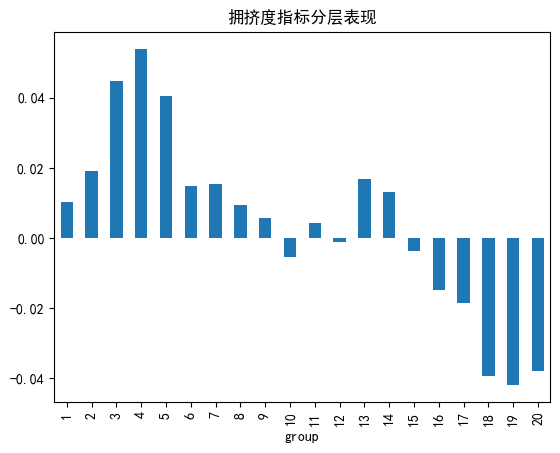

In [25]:
plt.rcParams['font.sans-serif']=['SimHei']
plt.rcParams['axes.unicode_minus']=False
crowd_combo_ret60.groupby(['group']).ret_60.mean().plot(kind = 'bar',title = '拥挤度指标分层表现')

#### 回测

In [120]:
# 可做空
net = (barra_return['momentum'] * ((crowd_combo_ret60.group == 18) | (crowd_combo_ret60.group == 19) | (crowd_combo_ret60.group == 20)).replace(False,np.nan).ffill(limit = 59).isnull().replace(False,-1).replace(True,1)).dropna()

cumnet = (net + 1).cumprod()

cumnet_compare = pd.concat([net.to_frame('crowd_fix'),barra_return['momentum'].to_frame('benchamrk')],axis = 1).dropna()
cumnet_compare = (cumnet_compare + 1).cumprod()
cumnet_compare['alpha'] = cumnet_compare['crowd_fix']/cumnet_compare['benchamrk']

,净值,年化收益率,夏普比率,最大回测,波动率
crowd_fix,1.4380,9.44,1.10,6.60,5.83
benchamrk,1.0342,0.84,-0.37,18.59,5.86
alpha,1.3905,8.53,0.81,5.84,6.83


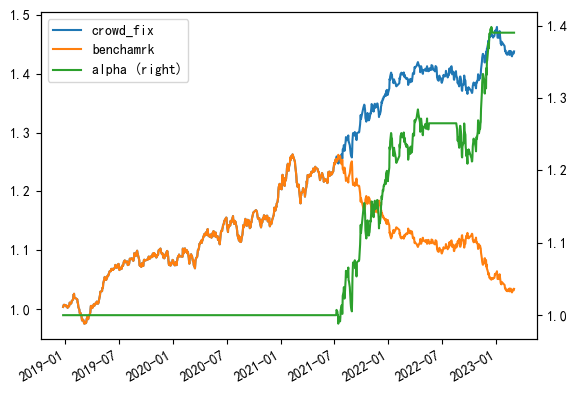

In [121]:
cumnet_compare.plot(secondary_y='alpha')
performance = pd.DataFrame()
for i in cumnet_compare.columns.tolist():
    temp = pd.DataFrame(get_Performance_analysis(cumnet_compare[i]),columns= [i]).T
    performance = pd.concat([performance,temp],axis = 0)
performance.columns = ['净值','年化收益率','夏普比率','最大回测','波动率']

performance

In [118]:
# 不可做空
net = (barra_return['momentum'] * ((crowd_combo_ret60.group == 18) | (crowd_combo_ret60.group == 19) | (crowd_combo_ret60.group == 20)).replace(False,np.nan).ffill(limit = 59).isnull().replace(False,0).replace(True,1)).dropna()

cumnet = (net + 1).cumprod()

cumnet_compare = pd.concat([net.to_frame('crowd_fix'),barra_return['momentum'].to_frame('benchamrk')],axis = 1).dropna()
cumnet_compare = (cumnet_compare + 1).cumprod()
cumnet_compare['alpha'] = cumnet_compare['crowd_fix']/cumnet_compare['benchamrk']

,净值,年化收益率,夏普比率,最大回测,波动率
crowd_fix,1.2224,5.11,0.44,6.60,4.75
benchamrk,1.0342,0.84,-0.37,18.59,5.86
alpha,1.1819,4.24,0.36,2.93,3.42


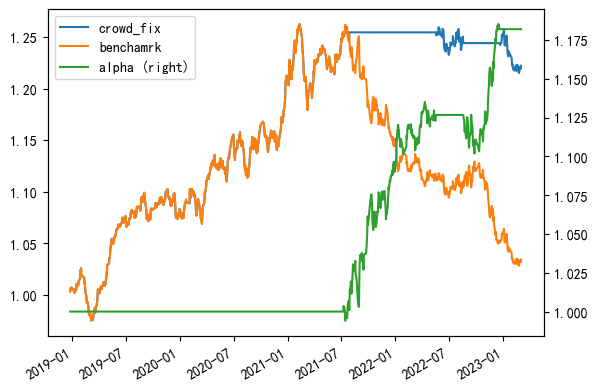

In [119]:
cumnet_compare.plot(secondary_y='alpha')
performance = pd.DataFrame()
for i in cumnet_compare.columns.tolist():
    temp = pd.DataFrame(get_Performance_analysis(cumnet_compare[i]),columns= [i]).T
    performance = pd.concat([performance,temp],axis = 0)
performance.columns = ['净值','年化收益率','夏普比率','最大回测','波动率']

performance

### 修正因子合成（时序标准分）

这种方法需要消耗的预处理数据会比较多

In [34]:
momentum_crowd_z = pd.concat([((momentum_crowd - momentum_crowd.rolling(240).mean())/momentum_crowd.rolling(240).std()).dropna()[['bp_spread','match_bottom','match_top','match_top_bottom','std_top','std_top_bottom','turn_top']],momentum_crowd[['factor_ret5','factor_ret20','factor_ret60']]],axis = 1).dropna()

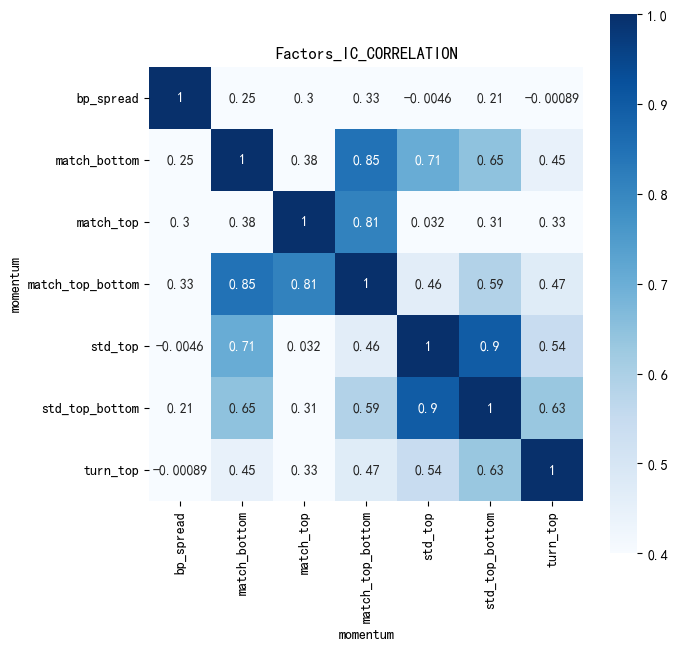

In [35]:
hot_corr(momentum_crowd_z.columns.tolist()[:-3],momentum_crowd)

<AxesSubplot: title={'center': 'momentum_crowd_z240'}, xlabel='momentum'>

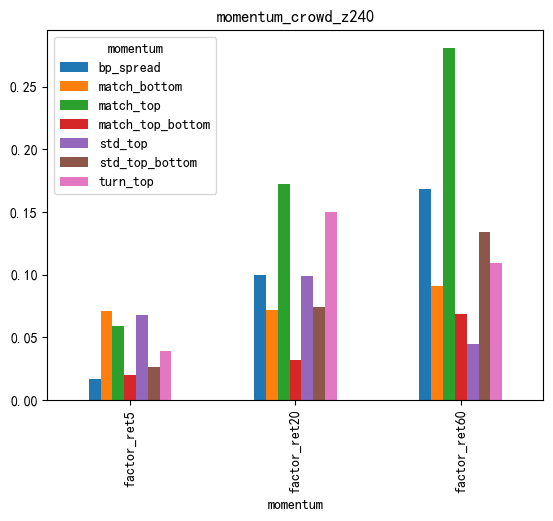

In [38]:
momentum_crowd_z.corr().loc[:'turn_top','factor_ret5':].abs().T.plot(kind = 'bar',title = 'momentum_crowd_z240')

In [39]:
# 时序动态因子与未来20日相关性
momentum_crowd_z_corr_ts = momentum_crowd_z.rolling(240).corr().dropna()['factor_ret20'].unstack('momentum')[['bp_spread','match_bottom','match_top','match_top_bottom','std_top','std_top_bottom','turn_top']]

<AxesSubplot: >

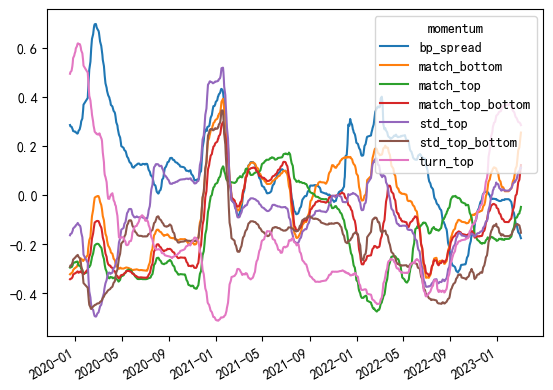

In [40]:
momentum_crowd_z_corr_ts.plot()

In [344]:
momentum_crowd_z_corr_ts.std()

momentum
bp_spread           0.186112
match_bottom        0.170371
match_top           0.173223
match_top_bottom    0.150675
std_top             0.186981
std_top_bottom      0.149538
turn_top            0.251524
dtype: float64

#### 动态加权合成尝试

In [41]:
factor_ret20 = barra_return['momentum'].rolling(20).sum().shift(-20)
- momentum_crowd_z[['bp_spread','match_bottom','match_top','match_top_bottom','std_top','std_top_bottom','turn_top']].mul(momentum_crowd_z_corr_ts,axis = 0).dropna().sum(axis = 1).corr(factor_ret20)

-0.1412330752124233

In [42]:
# del ['match_top_bottom','std_top']
- momentum_crowd_z[['bp_spread','match_bottom','match_top','match_top_bottom','std_top','std_top_bottom','turn_top']].mul(momentum_crowd_z_corr_ts,axis = 0).dropna().drop(['bp_spread','match_bottom','match_top_bottom','std_top','std_top_bottom'],axis = 1).sum(axis = 1).corr(factor_ret20)

-0.18403905527235281

In [43]:
- momentum_crowd_z[['bp_spread','match_bottom','match_top','match_top_bottom','std_top','std_top_bottom','turn_top']].mul(momentum_crowd_z_corr_ts,axis = 0).dropna().drop(['match_bottom','match_top_bottom','std_top'],axis = 1).sum(axis = 1).corr(factor_ret20)

-0.1000540658543952

In [44]:
# del ['match_top_bottom','std_top']
- momentum_crowd_z[['bp_spread','match_bottom','match_top','match_top_bottom','std_top','std_top_bottom','turn_top']].mul(momentum_crowd_z_corr_ts,axis = 0).dropna().drop(['bp_spread','match_bottom','match_top','match_top_bottom','std_top','std_top_bottom',],axis = 1).sum(axis = 1).corr(factor_ret20)

-0.13588153299889477

#### 最大化ICIR的逻辑进行

In [52]:
momentum_crowd_z_cov = momentum_crowd_z[['bp_spread','match_bottom','match_top','match_top_bottom','std_top','std_top_bottom','turn_top']].rolling(240).cov().dropna()

date_list = sorted(list(set(momentum_crowd_z_cov.index.get_level_values(0))))
momentum_crowd_z_ret_20 = momentum_crowd_z.rolling(240).corr().dropna()['factor_ret20']
weight = pd.DataFrame()
for i in tqdm(date_list):
    cov_temp = momentum_crowd_z_cov.loc[i]
    weight_temp = np.dot(np.linalg.inv(np.array(cov_temp)),momentum_crowd_z_ret_20.loc[i].loc[:'turn_top'])
    weight_temp = pd.DataFrame(weight_temp,index = ['bp_spread','match_bottom','match_top','match_top_bottom','std_top','std_top_bottom','turn_top'],columns = [i])
    weight = pd.concat([weight,weight_temp],axis = 1)

  0%|          | 0/776 [00:00<?, ?it/s]

100%|██████████| 776/776 [00:03<00:00, 243.93it/s]


In [53]:
- weight.T.mul(momentum_crowd_z,axis = 0).dropna(how = 'all',axis = 1).dropna(how = 'all',axis = 0).sum(axis = 1).corr(factor_ret20)

-0.24497772167297333

In [56]:
crowd_z_combo = - weight.T.mul(momentum_crowd_z,axis = 0).dropna(how = 'all',axis = 1).dropna(how = 'all',axis = 0).sum(axis = 1)

<AxesSubplot: >

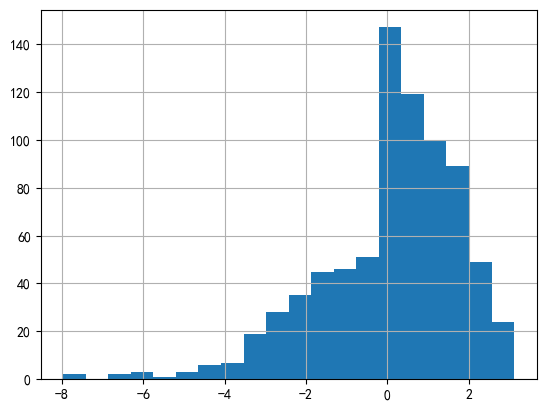

In [57]:
crowd_z_combo.hist(bins = 20)

In [63]:
crowd_combo_ret20 = pd.concat([crowd_z_combo.to_frame('crowd_z_combo'),factor_ret20.to_frame('ret_20')],axis= 1).dropna()
g = 5
crowd_combo_ret20.loc[:,'group'] = pd.qcut(crowd_combo_ret20.crowd_z_combo,g, list(range(1,g+1))).to_list()

<AxesSubplot: title={'center': '拥挤度指标分层表现'}, xlabel='group'>

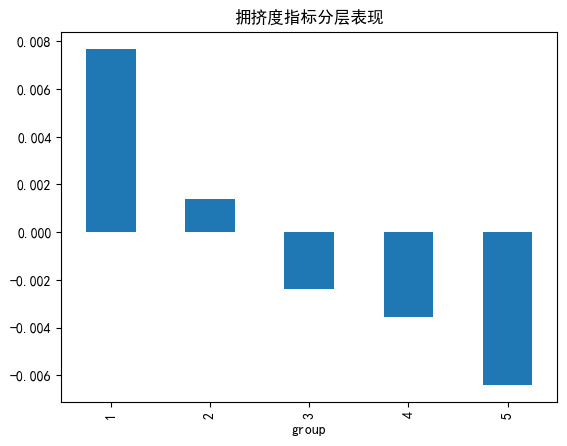

In [64]:
crowd_combo_ret20.groupby(['group']).ret_20.mean().plot(kind = 'bar',title = '拥挤度指标分层表现')

<AxesSubplot: >

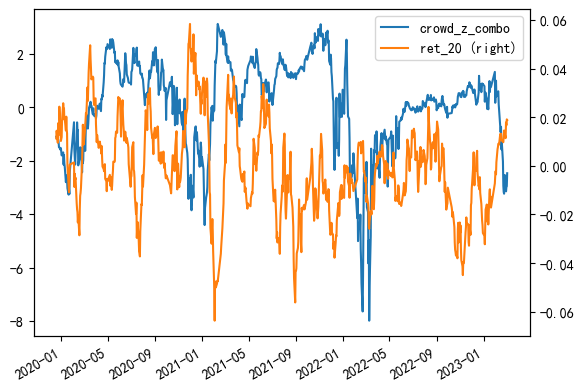

In [68]:
crowd_combo_ret20[['crowd_z_combo','ret_20']].plot(secondary_y='ret_20')

#### 回测

In [70]:
crowd_z_combo.quantile(0.8)

1.5178991034008096

In [157]:
# 可做空
net = (barra_return['momentum'] * ((crowd_z_combo > 1.5)).replace(False,np.nan).ffill(limit = 19).isnull().replace(False,-1).replace(True,1)).dropna()

cumnet = (net + 1).cumprod()

cumnet_compare = pd.concat([net.to_frame('crowd_fix'),barra_return['momentum'].to_frame('benchamrk')],axis = 1).dropna()
cumnet_compare = (cumnet_compare + 1).cumprod()
cumnet_compare['alpha'] = cumnet_compare['crowd_fix']/cumnet_compare['benchamrk']

In [158]:
cumnet_compare

,crowd_fix,benchamrk,alpha
2019-12-19,0.997709,0.997709,1.000000
2019-12-20,0.997535,0.997535,1.000000
2019-12-23,1.001463,1.001463,1.000000
2019-12-24,0.996643,0.996643,1.000000
2019-12-25,0.998809,0.998809,1.000000
...,...,...,...
2023-02-27,1.210805,0.959052,1.262501
2023-02-28,1.209484,0.958006,1.262501
2023-03-01,1.209862,0.958306,1.262501
2023-03-02,1.209162,0.957751,1.262501


,净值,年化收益率,夏普比率,最大回测,波动率
crowd_fix,1.2120,6.44,0.55,9.58,6.22
benchamrk,0.9600,-1.32,-0.69,18.59,6.24
alpha,1.2625,7.86,0.56,8.92,8.71


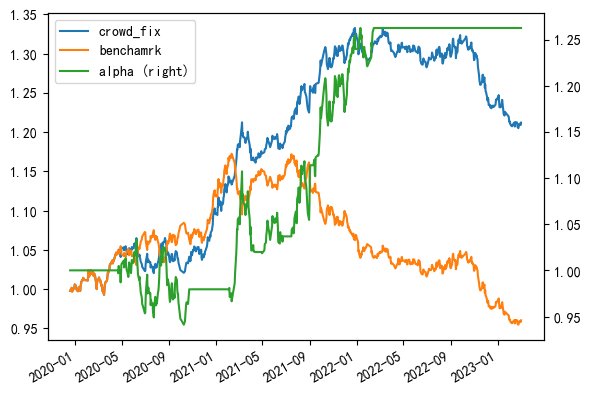

In [115]:
cumnet_compare.plot(secondary_y='alpha')
performance = pd.DataFrame()
for i in cumnet_compare.columns.tolist():
    temp = pd.DataFrame(get_Performance_analysis(cumnet_compare[i]),columns= [i]).T
    performance = pd.concat([performance,temp],axis = 0)
performance.columns = ['净值','年化收益率','夏普比率','最大回测','波动率']

performance

In [116]:
# 不可做空
net = (barra_return['momentum'] * ((crowd_z_combo > 1.5)).replace(False,np.nan).ffill(limit = 19).isnull().replace(False,0).replace(True,1)).dropna()

cumnet = (net + 1).cumprod()

cumnet_compare = pd.concat([net.to_frame('crowd_fix'),barra_return['momentum'].to_frame('benchamrk')],axis = 1).dropna()
cumnet_compare = (cumnet_compare + 1).cumprod()
cumnet_compare['alpha'] = cumnet_compare['crowd_fix']/cumnet_compare['benchamrk']

,净值,年化收益率,夏普比率,最大回测,波动率
crowd_fix,1.0818,2.59,-0.09,9.99,4.47
benchamrk,0.9600,-1.32,-0.69,18.59,6.24
alpha,1.1269,3.96,0.22,4.50,4.35


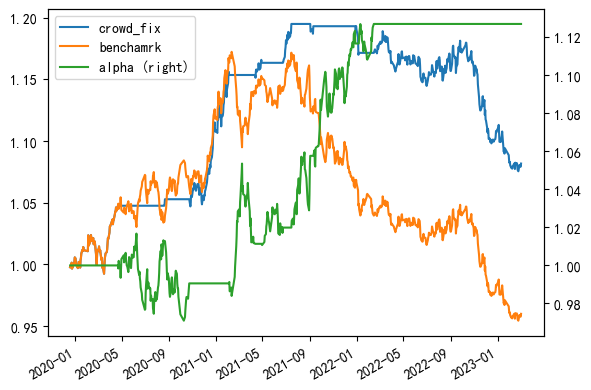

In [117]:
cumnet_compare.plot(secondary_y='alpha')
performance = pd.DataFrame()
for i in cumnet_compare.columns.tolist():
    temp = pd.DataFrame(get_Performance_analysis(cumnet_compare[i]),columns= [i]).T
    performance = pd.concat([performance,temp],axis = 0)
performance.columns = ['净值','年化收益率','夏普比率','最大回测','波动率']

performance

### 随机森林测试

In [78]:
from sklearn.model_selection import train_test_split    #训练集拆分   经济学意义 
from sklearn.model_selection import KFold,cross_validate
from sklearn.ensemble import RandomForestClassifier     #随机森林

from sklearn import metrics
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import confusion_matrix,accuracy_score,roc_curve,classification_report

#### factor_ret5

In [77]:
factor_ret5 = barra_return['momentum'].rolling(5).sum().shift(-5)
momentum_crowd = momentum_crowd.dropna()
momentum_crowd['target'] = (factor_ret5 > 0).astype(int)

In [79]:
num = momentum_crowd.shape[0]

x_test_predict = pd.DataFrame()
randomforest_acc_score = []
for i in tqdm(range(240,num-20,20)):
    momentum_crowd_slice = momentum_crowd.iloc[i - 240:i+20]
    x_train = momentum_crowd_slice.loc[:,'bp_spread':'turn_top'].iloc[:240]
    y_train = momentum_crowd_slice.loc[:,'target'].iloc[:240]
    x_test = momentum_crowd_slice.loc[:,'bp_spread':'turn_top'].iloc[240:]
    y_test = momentum_crowd_slice.loc[:,'target'].iloc[240:]
    features = x_train.columns    

    rf_grid = {
            'max_depth':np.arange(3,15,3),
            'ccp_alpha':np.logspace(-5,-1,5)
            }

    rf_gscv = GridSearchCV(RandomForestClassifier(n_estimators = 50,max_features = 'sqrt',random_state = 0),
                            param_grid=rf_grid,
                            cv=5,
                            n_jobs = -1,
                            verbose=True,
                            )

    rf_gscv.fit(x_train, y_train)
    rf = rf_gscv.best_estimator_
    rf.fit(x_train, y_train)
    randomforest_predicted = rf.predict(x_test)
    #randomforest_conf_matrix = confusion_matrix(y_test, randomforest_predicted)
    randomforest_acc_score.append(accuracy_score(y_test, randomforest_predicted))

    x_test['predict'] = randomforest_predicted
    x_test_predict = pd.concat([x_test_predict,x_test['predict']],axis = 0)

  0%|          | 0/50 [00:00<?, ?it/s]

Fitting 5 folds for each of 20 candidates, totalling 100 fits


  2%|▏         | 1/50 [00:06<05:14,  6.41s/it]

Fitting 5 folds for each of 20 candidates, totalling 100 fits


  4%|▍         | 2/50 [00:08<03:08,  3.92s/it]

Fitting 5 folds for each of 20 candidates, totalling 100 fits


  6%|▌         | 3/50 [00:10<02:28,  3.15s/it]

Fitting 5 folds for each of 20 candidates, totalling 100 fits


  8%|▊         | 4/50 [00:13<02:16,  2.98s/it]

Fitting 5 folds for each of 20 candidates, totalling 100 fits


 10%|█         | 5/50 [00:16<02:09,  2.88s/it]

Fitting 5 folds for each of 20 candidates, totalling 100 fits


 12%|█▏        | 6/50 [00:18<01:57,  2.68s/it]

Fitting 5 folds for each of 20 candidates, totalling 100 fits


 14%|█▍        | 7/50 [00:20<01:50,  2.58s/it]

Fitting 5 folds for each of 20 candidates, totalling 100 fits


 16%|█▌        | 8/50 [00:23<01:43,  2.47s/it]

Fitting 5 folds for each of 20 candidates, totalling 100 fits


 18%|█▊        | 9/50 [00:25<01:39,  2.43s/it]

Fitting 5 folds for each of 20 candidates, totalling 100 fits


 20%|██        | 10/50 [00:27<01:33,  2.34s/it]

Fitting 5 folds for each of 20 candidates, totalling 100 fits


 22%|██▏       | 11/50 [00:29<01:30,  2.32s/it]

Fitting 5 folds for each of 20 candidates, totalling 100 fits


 24%|██▍       | 12/50 [00:32<01:31,  2.40s/it]

Fitting 5 folds for each of 20 candidates, totalling 100 fits


 26%|██▌       | 13/50 [00:34<01:26,  2.34s/it]

Fitting 5 folds for each of 20 candidates, totalling 100 fits


 28%|██▊       | 14/50 [00:36<01:23,  2.33s/it]

Fitting 5 folds for each of 20 candidates, totalling 100 fits


 30%|███       | 15/50 [00:39<01:25,  2.44s/it]

Fitting 5 folds for each of 20 candidates, totalling 100 fits


 32%|███▏      | 16/50 [00:42<01:22,  2.44s/it]

Fitting 5 folds for each of 20 candidates, totalling 100 fits


 34%|███▍      | 17/50 [00:44<01:22,  2.49s/it]

Fitting 5 folds for each of 20 candidates, totalling 100 fits


 36%|███▌      | 18/50 [00:47<01:21,  2.55s/it]

Fitting 5 folds for each of 20 candidates, totalling 100 fits


 38%|███▊      | 19/50 [00:49<01:17,  2.50s/it]

Fitting 5 folds for each of 20 candidates, totalling 100 fits


 40%|████      | 20/50 [00:58<02:07,  4.25s/it]

Fitting 5 folds for each of 20 candidates, totalling 100 fits


 42%|████▏     | 21/50 [01:00<01:45,  3.65s/it]

Fitting 5 folds for each of 20 candidates, totalling 100 fits


 44%|████▍     | 22/50 [01:02<01:28,  3.17s/it]

Fitting 5 folds for each of 20 candidates, totalling 100 fits


 46%|████▌     | 23/50 [01:04<01:19,  2.93s/it]

Fitting 5 folds for each of 20 candidates, totalling 100 fits


 48%|████▊     | 24/50 [01:07<01:14,  2.85s/it]

Fitting 5 folds for each of 20 candidates, totalling 100 fits


 50%|█████     | 25/50 [01:10<01:09,  2.77s/it]

Fitting 5 folds for each of 20 candidates, totalling 100 fits


 52%|█████▏    | 26/50 [01:12<01:03,  2.66s/it]

Fitting 5 folds for each of 20 candidates, totalling 100 fits


 54%|█████▍    | 27/50 [01:20<01:38,  4.27s/it]

Fitting 5 folds for each of 20 candidates, totalling 100 fits


 56%|█████▌    | 28/50 [01:22<01:18,  3.55s/it]

Fitting 5 folds for each of 20 candidates, totalling 100 fits


 58%|█████▊    | 29/50 [01:24<01:05,  3.14s/it]

Fitting 5 folds for each of 20 candidates, totalling 100 fits


 60%|██████    | 30/50 [01:26<00:57,  2.89s/it]

Fitting 5 folds for each of 20 candidates, totalling 100 fits


 62%|██████▏   | 31/50 [01:29<00:52,  2.77s/it]

Fitting 5 folds for each of 20 candidates, totalling 100 fits


 64%|██████▍   | 32/50 [01:31<00:48,  2.67s/it]

Fitting 5 folds for each of 20 candidates, totalling 100 fits


 66%|██████▌   | 33/50 [01:33<00:42,  2.50s/it]

Fitting 5 folds for each of 20 candidates, totalling 100 fits


 68%|██████▊   | 34/50 [01:41<01:05,  4.11s/it]

Fitting 5 folds for each of 20 candidates, totalling 100 fits


 70%|███████   | 35/50 [01:43<00:52,  3.53s/it]

Fitting 5 folds for each of 20 candidates, totalling 100 fits


 72%|███████▏  | 36/50 [01:46<00:43,  3.13s/it]

Fitting 5 folds for each of 20 candidates, totalling 100 fits


 74%|███████▍  | 37/50 [01:48<00:36,  2.78s/it]

Fitting 5 folds for each of 20 candidates, totalling 100 fits


 76%|███████▌  | 38/50 [01:50<00:30,  2.57s/it]

Fitting 5 folds for each of 20 candidates, totalling 100 fits


 78%|███████▊  | 39/50 [01:52<00:26,  2.42s/it]

Fitting 5 folds for each of 20 candidates, totalling 100 fits


 80%|████████  | 40/50 [01:59<00:39,  3.99s/it]

Fitting 5 folds for each of 20 candidates, totalling 100 fits


 82%|████████▏ | 41/50 [02:01<00:30,  3.37s/it]

Fitting 5 folds for each of 20 candidates, totalling 100 fits


 84%|████████▍ | 42/50 [02:04<00:26,  3.28s/it]

Fitting 5 folds for each of 20 candidates, totalling 100 fits


 86%|████████▌ | 43/50 [02:08<00:24,  3.53s/it]

Fitting 5 folds for each of 20 candidates, totalling 100 fits


 88%|████████▊ | 44/50 [02:15<00:25,  4.31s/it]

Fitting 5 folds for each of 20 candidates, totalling 100 fits


 90%|█████████ | 45/50 [02:19<00:20,  4.20s/it]

Fitting 5 folds for each of 20 candidates, totalling 100 fits


 92%|█████████▏| 46/50 [02:22<00:15,  3.99s/it]

Fitting 5 folds for each of 20 candidates, totalling 100 fits


 94%|█████████▍| 47/50 [02:25<00:11,  3.78s/it]

Fitting 5 folds for each of 20 candidates, totalling 100 fits


 96%|█████████▌| 48/50 [02:28<00:07,  3.56s/it]

Fitting 5 folds for each of 20 candidates, totalling 100 fits


 98%|█████████▊| 49/50 [02:31<00:03,  3.22s/it]

Fitting 5 folds for each of 20 candidates, totalling 100 fits


100%|██████████| 50/50 [02:33<00:00,  3.07s/it]


<AxesSubplot: title={'center': 'signal_ret5'}>

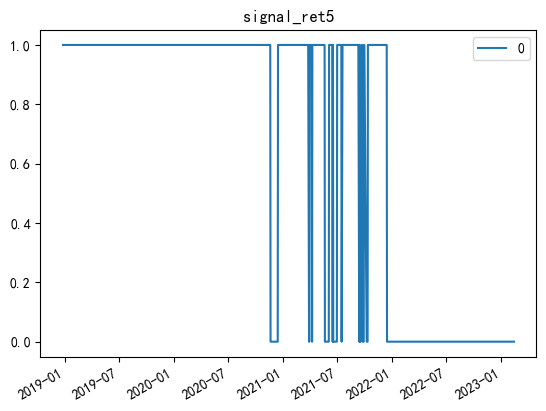

In [80]:
x_test_predict.plot(title = 'signal_ret5')

<AxesSubplot: >

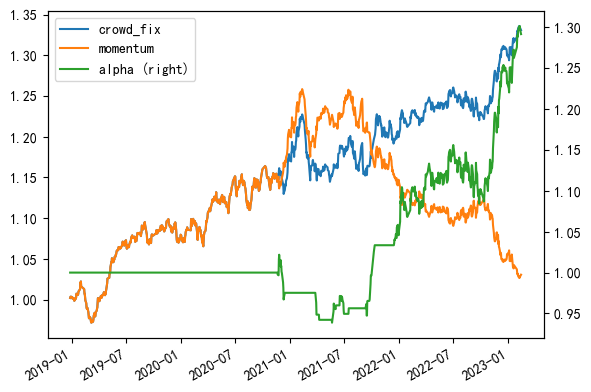

In [81]:
# 可做空
cumnet_compare = pd.concat([(x_test_predict.iloc[:,0].replace(0,-1)*barra_return['momentum']).to_frame('crowd_fix'),barra_return['momentum']],axis = 1).dropna()
cumnet_compare = (cumnet_compare + 1).cumprod()
cumnet_compare['alpha'] = cumnet_compare['crowd_fix']/cumnet_compare['momentum']
cumnet_compare.plot(secondary_y='alpha')

<AxesSubplot: >

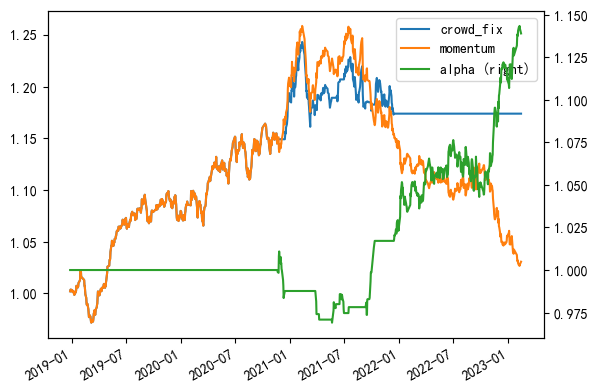

In [82]:
# 不可做空
cumnet_compare = pd.concat([(x_test_predict.iloc[:,0]*barra_return['momentum']).to_frame('crowd_fix'),barra_return['momentum']],axis = 1).dropna()
cumnet_compare = (cumnet_compare + 1).cumprod()
cumnet_compare['alpha'] = cumnet_compare['crowd_fix']/cumnet_compare['momentum']
cumnet_compare.plot(secondary_y='alpha')

#### factor_ret20

In [136]:
factor_ret20 = barra_return['momentum'].rolling(20).sum().shift(-20)
momentum_crowd = momentum_crowd.dropna()
momentum_crowd['target'] = (factor_ret20 > 0).astype(int)

In [138]:
num = momentum_crowd.shape[0]

x_test_predict_ret_20 = pd.DataFrame()
randomforest_acc_score = []
for i in tqdm(range(240,num-20,20)):
    momentum_crowd_slice = momentum_crowd.iloc[i - 240:i+20]
    x_train = momentum_crowd_slice.loc[:,'bp_spread':'turn_top'].iloc[:240]
    y_train = momentum_crowd_slice.loc[:,'target'].iloc[:240]
    x_test = momentum_crowd_slice.loc[:,'bp_spread':'turn_top'].iloc[240:]
    y_test = momentum_crowd_slice.loc[:,'target'].iloc[240:]
    features = x_train.columns    

    rf_grid = {
            'max_depth':np.arange(3,15,3),
            'ccp_alpha':np.logspace(-5,-1,5)
            }

    rf_gscv = GridSearchCV(RandomForestClassifier(n_estimators = 50,max_features = 'sqrt',random_state = 0),
                            param_grid=rf_grid,
                            cv=5,
                            n_jobs = -1,
                            verbose=True,
                            )

    rf_gscv.fit(x_train, y_train)
    rf = rf_gscv.best_estimator_
    rf.fit(x_train, y_train)
    randomforest_predicted = rf.predict(x_test)
    #randomforest_conf_matrix = confusion_matrix(y_test, randomforest_predicted)
    randomforest_acc_score.append(accuracy_score(y_test, randomforest_predicted))

    x_test['predict'] = randomforest_predicted
    x_test_predict_ret_20 = pd.concat([x_test_predict_ret_20,x_test['predict']],axis = 0)

  0%|          | 0/50 [00:00<?, ?it/s]

Fitting 5 folds for each of 20 candidates, totalling 100 fits


  2%|▏         | 1/50 [00:05<04:41,  5.75s/it]

Fitting 5 folds for each of 20 candidates, totalling 100 fits


  4%|▍         | 2/50 [00:07<02:48,  3.52s/it]

Fitting 5 folds for each of 20 candidates, totalling 100 fits


  6%|▌         | 3/50 [00:09<02:14,  2.85s/it]

Fitting 5 folds for each of 20 candidates, totalling 100 fits


  8%|▊         | 4/50 [00:11<01:56,  2.53s/it]

Fitting 5 folds for each of 20 candidates, totalling 100 fits


 10%|█         | 5/50 [00:13<01:46,  2.36s/it]

Fitting 5 folds for each of 20 candidates, totalling 100 fits


 12%|█▏        | 6/50 [00:15<01:38,  2.24s/it]

Fitting 5 folds for each of 20 candidates, totalling 100 fits


 14%|█▍        | 7/50 [00:17<01:33,  2.16s/it]

Fitting 5 folds for each of 20 candidates, totalling 100 fits


 16%|█▌        | 8/50 [00:25<02:44,  3.92s/it]

Fitting 5 folds for each of 20 candidates, totalling 100 fits


 18%|█▊        | 9/50 [00:27<02:14,  3.28s/it]

Fitting 5 folds for each of 20 candidates, totalling 100 fits


 20%|██        | 10/50 [00:29<01:54,  2.85s/it]

Fitting 5 folds for each of 20 candidates, totalling 100 fits


 22%|██▏       | 11/50 [00:31<01:40,  2.58s/it]

Fitting 5 folds for each of 20 candidates, totalling 100 fits


 24%|██▍       | 12/50 [00:33<01:31,  2.41s/it]

Fitting 5 folds for each of 20 candidates, totalling 100 fits


 26%|██▌       | 13/50 [00:35<01:24,  2.27s/it]

Fitting 5 folds for each of 20 candidates, totalling 100 fits


 28%|██▊       | 14/50 [00:41<02:08,  3.57s/it]

Fitting 5 folds for each of 20 candidates, totalling 100 fits


 30%|███       | 15/50 [00:44<01:59,  3.43s/it]

Fitting 5 folds for each of 20 candidates, totalling 100 fits


 32%|███▏      | 16/50 [00:46<01:40,  2.95s/it]

Fitting 5 folds for each of 20 candidates, totalling 100 fits


 34%|███▍      | 17/50 [00:48<01:27,  2.65s/it]

Fitting 5 folds for each of 20 candidates, totalling 100 fits


 36%|███▌      | 18/50 [00:50<01:18,  2.44s/it]

Fitting 5 folds for each of 20 candidates, totalling 100 fits


 38%|███▊      | 19/50 [00:52<01:12,  2.32s/it]

Fitting 5 folds for each of 20 candidates, totalling 100 fits


 40%|████      | 20/50 [00:55<01:10,  2.34s/it]

Fitting 5 folds for each of 20 candidates, totalling 100 fits


 42%|████▏     | 21/50 [01:02<01:56,  4.01s/it]

Fitting 5 folds for each of 20 candidates, totalling 100 fits


 44%|████▍     | 22/50 [01:04<01:34,  3.38s/it]

Fitting 5 folds for each of 20 candidates, totalling 100 fits


 46%|████▌     | 23/50 [01:07<01:20,  3.00s/it]

Fitting 5 folds for each of 20 candidates, totalling 100 fits


 48%|████▊     | 24/50 [01:09<01:10,  2.70s/it]

Fitting 5 folds for each of 20 candidates, totalling 100 fits


 50%|█████     | 25/50 [01:11<01:03,  2.53s/it]

Fitting 5 folds for each of 20 candidates, totalling 100 fits


 52%|█████▏    | 26/50 [01:18<01:38,  4.11s/it]

Fitting 5 folds for each of 20 candidates, totalling 100 fits


 54%|█████▍    | 27/50 [01:20<01:19,  3.46s/it]

Fitting 5 folds for each of 20 candidates, totalling 100 fits


 56%|█████▌    | 28/50 [01:22<01:06,  3.01s/it]

Fitting 5 folds for each of 20 candidates, totalling 100 fits


 58%|█████▊    | 29/50 [01:24<00:56,  2.70s/it]

Fitting 5 folds for each of 20 candidates, totalling 100 fits


 60%|██████    | 30/50 [01:26<00:50,  2.50s/it]

Fitting 5 folds for each of 20 candidates, totalling 100 fits


 62%|██████▏   | 31/50 [01:32<01:04,  3.39s/it]

Fitting 5 folds for each of 20 candidates, totalling 100 fits


 64%|██████▍   | 32/50 [01:36<01:06,  3.69s/it]

Fitting 5 folds for each of 20 candidates, totalling 100 fits


 66%|██████▌   | 33/50 [01:38<00:53,  3.17s/it]

Fitting 5 folds for each of 20 candidates, totalling 100 fits


 68%|██████▊   | 34/50 [01:40<00:44,  2.81s/it]

Fitting 5 folds for each of 20 candidates, totalling 100 fits


 70%|███████   | 35/50 [01:42<00:38,  2.56s/it]

Fitting 5 folds for each of 20 candidates, totalling 100 fits


 72%|███████▏  | 36/50 [02:00<01:38,  7.05s/it]

Fitting 5 folds for each of 20 candidates, totalling 100 fits


 74%|███████▍  | 37/50 [02:11<01:48,  8.36s/it]

Fitting 5 folds for each of 20 candidates, totalling 100 fits


 76%|███████▌  | 38/50 [02:15<01:25,  7.13s/it]

Fitting 5 folds for each of 20 candidates, totalling 100 fits


 78%|███████▊  | 39/50 [02:18<01:03,  5.82s/it]

Fitting 5 folds for each of 20 candidates, totalling 100 fits


 80%|████████  | 40/50 [02:21<00:48,  4.83s/it]

Fitting 5 folds for each of 20 candidates, totalling 100 fits


 82%|████████▏ | 41/50 [02:23<00:36,  4.10s/it]

Fitting 5 folds for each of 20 candidates, totalling 100 fits


 84%|████████▍ | 42/50 [02:25<00:27,  3.48s/it]

Fitting 5 folds for each of 20 candidates, totalling 100 fits


 86%|████████▌ | 43/50 [02:27<00:21,  3.06s/it]

Fitting 5 folds for each of 20 candidates, totalling 100 fits


 88%|████████▊ | 44/50 [02:29<00:16,  2.82s/it]

Fitting 5 folds for each of 20 candidates, totalling 100 fits


 90%|█████████ | 45/50 [02:32<00:13,  2.69s/it]

Fitting 5 folds for each of 20 candidates, totalling 100 fits


 92%|█████████▏| 46/50 [02:34<00:10,  2.69s/it]

Fitting 5 folds for each of 20 candidates, totalling 100 fits


 94%|█████████▍| 47/50 [02:37<00:07,  2.53s/it]

Fitting 5 folds for each of 20 candidates, totalling 100 fits


 96%|█████████▌| 48/50 [02:39<00:04,  2.44s/it]

Fitting 5 folds for each of 20 candidates, totalling 100 fits


 98%|█████████▊| 49/50 [02:41<00:02,  2.39s/it]

Fitting 5 folds for each of 20 candidates, totalling 100 fits


100%|██████████| 50/50 [02:44<00:00,  3.28s/it]


In [156]:
confusion_matrix(y_test, randomforest_predicted) + confusion_matrix(y_test, randomforest_predicted)

array([[26,  0],
       [14,  0]], dtype=int64)

In [149]:
print('平均预测精度:',np.array(randomforest_acc_score).mean())
print('预测精度:',randomforest_acc_score)

平均预测精度: 0.635
预测精度: [0.25, 0.8, 1.0, 1.0, 1.0, 0.95, 1.0, 0.55, 0.55, 1.0, 0.2, 0.85, 0.05, 0.2, 1.0, 0.8, 0.4, 1.0, 0.25, 0.8, 0.9, 0.55, 0.65, 1.0, 0.6, 0.1, 0.75, 0.75, 0.5, 0.05, 0.45, 0.15, 0.9, 0.8, 0.65, 1.0, 0.9, 0.65, 0.15, 0.4, 0.65, 0.9, 0.1, 0.25, 0.2, 0.7, 1.0, 0.9, 0.85, 0.65]


<AxesSubplot: title={'center': 'signal_ret20'}>

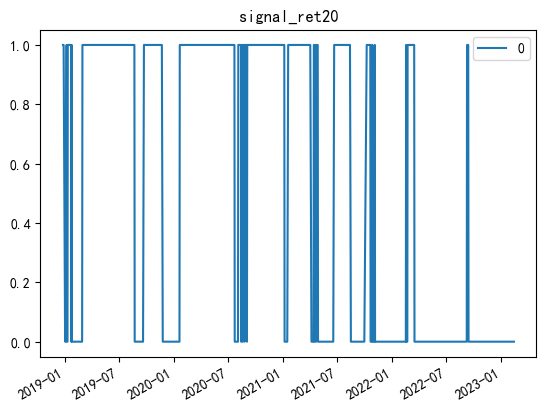

In [142]:
x_test_predict_ret_20.plot(title = 'signal_ret20')

In [151]:
# 可做空
cumnet_compare = pd.concat([(x_test_predict_ret_20.iloc[:,0].replace(0,-1)*barra_return['momentum']).to_frame('crowd_fix'),barra_return['momentum']],axis = 1).dropna()
cumnet_compare = (cumnet_compare + 1).cumprod()
cumnet_compare['alpha'] = cumnet_compare['crowd_fix']/cumnet_compare['momentum']

,净值,年化收益率,夏普比率,最大回测,波动率
crowd_fix,1.5988,12.55,1.64,6.60,5.84
momentum,1.0306,0.76,-0.38,18.43,5.88
alpha,1.5514,11.70,1.07,7.79,8.10


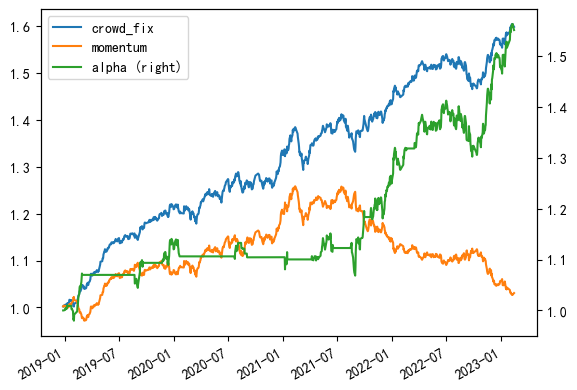

In [152]:
cumnet_compare.plot(secondary_y='alpha')
performance = pd.DataFrame()
for i in cumnet_compare.columns.tolist():
    temp = pd.DataFrame(get_Performance_analysis(cumnet_compare[i]),columns= [i]).T
    performance = pd.concat([performance,temp],axis = 0)
performance.columns = ['净值','年化收益率','夏普比率','最大回测','波动率']

performance

In [153]:
# 不可做空
cumnet_compare = pd.concat([(x_test_predict_ret_20.iloc[:,0]*barra_return['momentum']).to_frame('crowd_fix'),barra_return['momentum']],axis = 1).dropna()
cumnet_compare = (cumnet_compare + 1).cumprod()
cumnet_compare['alpha'] = cumnet_compare['crowd_fix']/cumnet_compare['momentum']

,净值,年化收益率,夏普比率,最大回测,波动率
crowd_fix,1.2878,6.58,0.84,6.60,4.24
momentum,1.0306,0.76,-0.38,18.43,5.88
alpha,1.2496,5.78,0.69,3.93,4.05


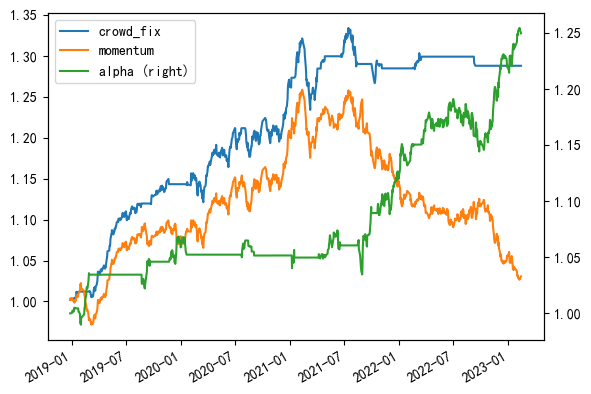

In [154]:
cumnet_compare.plot(secondary_y='alpha')
performance = pd.DataFrame()
for i in cumnet_compare.columns.tolist():
    temp = pd.DataFrame(get_Performance_analysis(cumnet_compare[i]),columns= [i]).T
    performance = pd.concat([performance,temp],axis = 0)
performance.columns = ['净值','年化收益率','夏普比率','最大回测','波动率']

performance

In [164]:
x_test_predict_ret_20.to_pickle('x_test_predict_ret_20.pkl')

#### factor_ret60

In [134]:
factor_ret60 = barra_return['momentum'].rolling(60).sum().shift(-60)
momentum_crowd = momentum_crowd.dropna()
momentum_crowd['target'] = (factor_ret60 > 0).astype(int)

In [ ]:
num = momentum_crowd.shape[0]

x_test_predict = pd.DataFrame()
randomforest_acc_score = []
for i in tqdm(range(240,num-20,20)):
    momentum_crowd_slice = momentum_crowd.iloc[i - 240:i+20]
    x_train = momentum_crowd_slice.loc[:,'bp_spread':'turn_top'].iloc[:240]
    y_train = momentum_crowd_slice.loc[:,'target'].iloc[:240]
    x_test = momentum_crowd_slice.loc[:,'bp_spread':'turn_top'].iloc[240:]
    y_test = momentum_crowd_slice.loc[:,'target'].iloc[240:]
    features = x_train.columns    

    rf_grid = {
            'max_depth':np.arange(3,15,3),
            'ccp_alpha':np.logspace(-5,-1,5)
            }

    rf_gscv = GridSearchCV(RandomForestClassifier(n_estimators = 50,max_features = 'sqrt',random_state = 0),
                            param_grid=rf_grid,
                            cv=5,
                            n_jobs = -1,
                            verbose=True,
                            )

    rf_gscv.fit(x_train, y_train)
    rf = rf_gscv.best_estimator_
    rf.fit(x_train, y_train)
    randomforest_predicted = rf.predict(x_test)
    #randomforest_conf_matrix = confusion_matrix(y_test, randomforest_predicted)
    randomforest_acc_score.append(accuracy_score(y_test, randomforest_predicted))

    x_test['predict'] = randomforest_predicted
    x_test_predict = pd.concat([x_test_predict,x_test['predict']],axis = 0)

In [133]:
print('平均预测精度:',np.array(randomforest_acc_score).mean())
print('预测精度:',randomforest_acc_score)

平均预测精度: 0.774
预测精度: [0.25, 0.95, 0.75, 0.6, 1.0, 0.7, 0.95, 0.95, 0.65, 0.7, 0.45, 0.6, 0.9, 1.0, 1.0, 1.0, 0.55, 0.55, 0.65, 0.85, 1.0, 1.0, 1.0, 1.0, 0.95, 0.35, 1.0, 1.0, 0.75, 0.55, 0.0, 0.95, 0.6, 0.5, 1.0, 1.0, 1.0, 1.0, 0.95, 1.0, 0.85, 0.65, 0.0, 0.55, 1.0, 1.0, 1.0, 1.0, 0.9, 0.1]


<AxesSubplot: title={'center': 'signal_ret60'}>

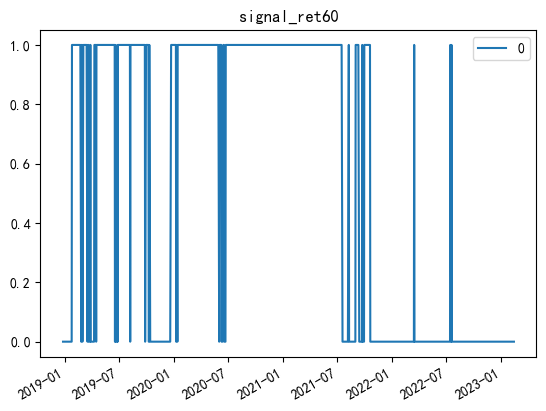

In [104]:
x_test_predict.plot(title = 'signal_ret60')

In [122]:
# 可做空
cumnet_compare = pd.concat([(x_test_predict.iloc[:,0].replace(0,-1)*barra_return['momentum']).to_frame('crowd_fix'),barra_return['momentum']],axis = 1).dropna()
cumnet_compare = (cumnet_compare + 1).cumprod()
cumnet_compare['alpha'] = cumnet_compare['crowd_fix']/cumnet_compare['momentum']

,净值,年化收益率,夏普比率,最大回测,波动率
crowd_fix,1.3267,7.38,0.75,6.93,5.87
momentum,1.0306,0.76,-0.38,18.43,5.88
alpha,1.2873,6.57,0.48,10.41,7.51


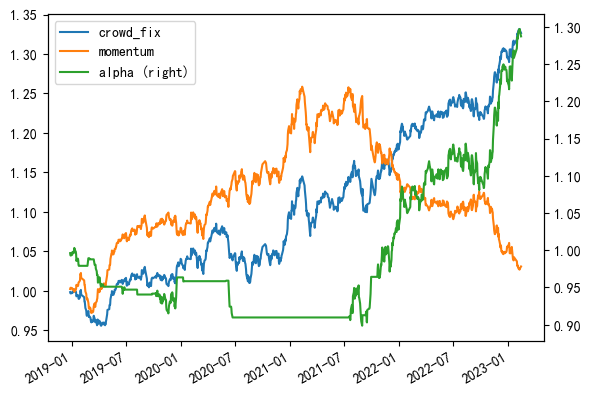

In [123]:
cumnet_compare.plot(secondary_y='alpha')
performance = pd.DataFrame()
for i in cumnet_compare.columns.tolist():
    temp = pd.DataFrame(get_Performance_analysis(cumnet_compare[i]),columns= [i]).T
    performance = pd.concat([performance,temp],axis = 0)
performance.columns = ['净值','年化收益率','夏普比率','最大回测','波动率']

performance

In [124]:
# 不可做空
cumnet_compare = pd.concat([(x_test_predict.iloc[:,0]*barra_return['momentum']).to_frame('crowd_fix'),barra_return['momentum']],axis = 1).dropna()
cumnet_compare = (cumnet_compare + 1).cumprod()
cumnet_compare['alpha'] = cumnet_compare['crowd_fix']/cumnet_compare['momentum']

,净值,年化收益率,夏普比率,最大回测,波动率
crowd_fix,1.1726,4.09,0.24,6.60,4.53
momentum,1.0306,0.76,-0.38,18.43,5.88
alpha,1.1378,3.31,0.08,5.29,3.75


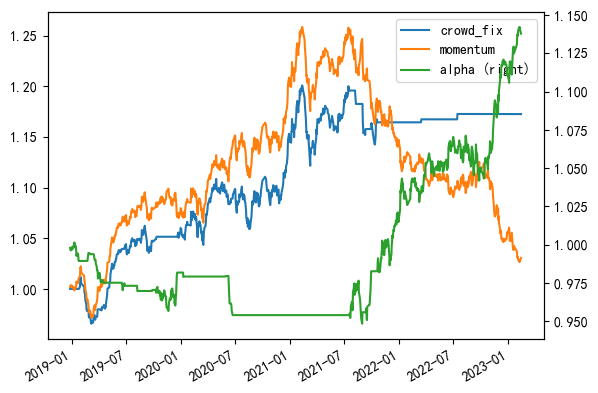

In [125]:
cumnet_compare.plot(secondary_y='alpha')
performance = pd.DataFrame()
for i in cumnet_compare.columns.tolist():
    temp = pd.DataFrame(get_Performance_analysis(cumnet_compare[i]),columns= [i]).T
    performance = pd.concat([performance,temp],axis = 0)
performance.columns = ['净值','年化收益率','夏普比率','最大回测','波动率']

performance

#### 匹配长度 factor_ret20

In [159]:
# 可做空
cumnet_compare = pd.concat([(x_test_predict_ret_20.iloc[:,0].replace(0,-1)*barra_return['momentum']).to_frame('crowd_fix'),barra_return['momentum']],axis = 1).dropna()
cumnet_compare = (cumnet_compare.loc['2019-12-19':] + 1).cumprod()
cumnet_compare['alpha'] = cumnet_compare['crowd_fix']/cumnet_compare['momentum']

,净值,年化收益率,夏普比率,最大回测,波动率
crowd_fix,1.3144,9.46,1.04,6.60,6.24
momentum,0.9600,-1.34,-0.69,18.43,6.27
alpha,1.3691,10.95,0.91,7.79,8.69


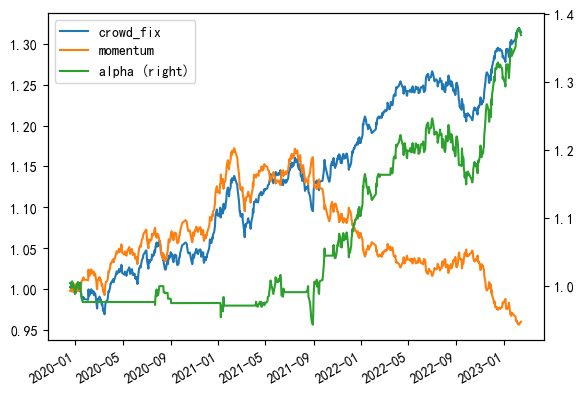

In [160]:
cumnet_compare.plot(secondary_y='alpha')
performance = pd.DataFrame()
for i in cumnet_compare.columns.tolist():
    temp = pd.DataFrame(get_Performance_analysis(cumnet_compare[i]),columns= [i]).T
    performance = pd.concat([performance,temp],axis = 0)
performance.columns = ['净值','年化收益率','夏普比率','最大回测','波动率']

performance

In [161]:
# 不可做空
cumnet_compare = pd.concat([(x_test_predict_ret_20.iloc[:,0]*barra_return['momentum']).to_frame('crowd_fix'),barra_return['momentum']],axis = 1).dropna()
cumnet_compare = (cumnet_compare + 1).cumprod()
cumnet_compare['alpha'] = cumnet_compare['crowd_fix']/cumnet_compare['momentum']

,净值,年化收益率,夏普比率,最大回测,波动率
crowd_fix,1.2878,6.58,0.84,6.60,4.24
momentum,1.0306,0.76,-0.38,18.43,5.88
alpha,1.2496,5.78,0.69,3.93,4.05


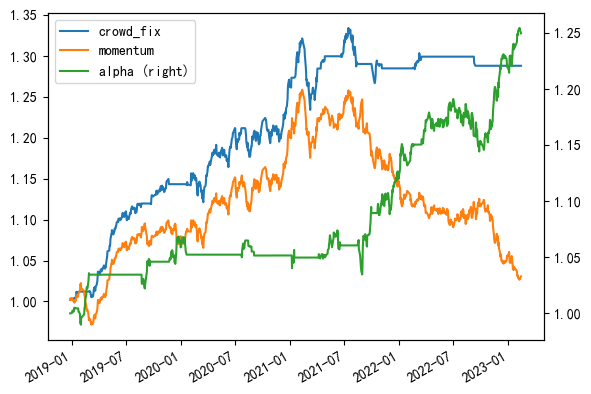

In [162]:
cumnet_compare.plot(secondary_y='alpha')
performance = pd.DataFrame()
for i in cumnet_compare.columns.tolist():
    temp = pd.DataFrame(get_Performance_analysis(cumnet_compare[i]),columns= [i]).T
    performance = pd.concat([performance,temp],axis = 0)
performance.columns = ['净值','年化收益率','夏普比率','最大回测','波动率']

performance